## **7PAM2015-0509-2024 -- Research Methods in Data Science**
### Group Kaggle Challenge on Spaceship Titanic -- Assignment-3
---
##### Spaceship Titanic Challenge link can be found [here](https://www.kaggle.com/competitions/spaceship-titanic/overview).

**Problem Statement:** When the Spaceship Titanic encountered a spacetime anomaly, some passengers were teleported to alternate dimensions while others remained aboard. Using passenger data including CryoSleep status, VIP services, cabin assignments, and spending patterns, develop a machine learning model to predict which passengers were transported.

**Data Columns description:** [Directly Taken from Kaggle Data Overview]

    PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    Destination - The planet the passenger will be debarking to.
    Age - The age of the passenger.
    VIP - Whether the passenger has paid for special VIP service during the voyage.
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    Name - The first and last names of the passenger.
    Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
---
**Group-3**

- **Mohit Agarwal                 (Student ID-22031257)**
- **Jerome Paulraj                (Student ID-22074395)**
- **Omkar Shashikant Sawant       (Student ID-22080770)**
- **somy Nellikkunnel Thomas      (Student ID-22079522)**
- **Chandra Shekar Losirlu        (Student ID-22081216)**
- **Hari Bahadur Gharti Magar     (Student ID-22075765)**
- **Yogesh Pandit                 (Student ID-22095146)**

### Import Libraries

In [1]:
# libraries import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import warnings
import optuna

from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, make_scorer

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

c:\Users\agarw\Python_VENV\spaceship_titanic_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting Palette For Plotting

In [2]:
# setting style
sns.set_style("darkgrid")
# setting context
sns.set_context("paper")
# setting palette
sns.set_palette("deep", color_codes=True)

### Defining Paths

In [3]:
# note: change the paths
# data path
data_path = r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Data"
# image save path
image_save_path = r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Images"
# kaggle submission path
kaggle_submission_path = r"D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Kaggle_Submissions"

### Loading Data

In [4]:
# reading the trian and test data
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))

### Functions & Classes

#### Function to Calculate the Missingness

In [5]:
def missing_data(df, plot=False, title="Number of Missing Data"):
    """
    Generate a summary of missing values in the DataFrame and optionally plot them.

    Computes the count and percentage of missing values for each column in the given
    DataFrame. If requested, it also generates and saves a horizontal bar plot of the
    missing value distribution.

    Args:
        df (pandas.DataFrame): Input DataFrame to analyze for missing values.
        plot (bool): Whether to generate a bar plot of missing value counts. Default False.
        title (str): Title for the plot if plotting is enabled. Default "Number of Missing Data".

    Raises:
        ValueError: If `df` is not a valid pandas DataFrame.

    Note:
        To save plots, ensure a global variable `image_save_path` exists and points to
        a valid directory.
    """

    # validate input type
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    # combine missing value counts and percentages into a summary DataFrame
    missing_df = pd.concat([df.isna().sum(),
                            np.round(df.isna().mean()*100, 2)],  # type: ignore
                           axis=1,
                           # type: ignore
                           keys=["MissingCount", "MissingPercentage"])

    if plot:
        # create horizontal bar plot of missing counts
        missing_df["MissingCount"].plot(
            kind="barh",
            figsize=(10, 6))

        # format plot with bold title and grid
        plt.title(title, fontsize=12, fontweight="bold")
        plt.xlabel("Missing Counts", fontweight="bold")
        plt.ylabel("Columns", fontweight="bold")
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # save plot image if image_save_path exists in global scope
        if "image_save_path" in globals():
            plt.savefig(os.path.join(image_save_path,
                        f"{title}.png"), bbox_inches="tight")

        # display the plot
        plt.show()

    # print missing value summary table
    print(missing_df)

#### Function to Visualise the Missingess

In [6]:
def missing_data_visualisation(df, title="Training"):
    """
    Visualize missing data patterns in the DataFrame using missingno.

    Generates and saves three common missing data plots:
    1. Matrix visualization showing locations and patterns of missing values.
    2. Nullity correlation heatmap indicating correlation between missingness in columns.
    3. Dendrogram clustering columns by similarity of missing data patterns.

    Args:
        df (pandas.DataFrame): DataFrame to analyze for missing data.
        title (str): Title to use in plot titles and filenames. Default is "Training".

    Raises:
        FileNotFoundError: If global variable `image_save_path` is not set or 
        points to invalid directory.

    Note:
        Requires a global variable `image_save_path` where plots will be saved.
        Ensure necessary imports: matplotlib.pyplot, os, missingno.
    """

    # Check if image_save_path exists globally and is valid
    if 'image_save_path' not in globals() or not os.path.isdir(image_save_path):
        raise FileNotFoundError(
            "Global variable 'image_save_path' must be set to a valid directory path."
        )

    # Matrix plot: visualizes missingness as white lines on dark background
    msno.matrix(df, figsize=(12, 8), fontsize=12)
    plt.title(f"Matrix Visualisation of Missing Data in {title} Set",
              fontsize=16, fontweight="bold")
    plt.xlabel("Columns (Features)", fontsize=12, fontweight="bold")
    plt.ylabel("Rows (Samples)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.savefig(os.path.join(image_save_path,
                             f"Matrix Visualisation of Missing Data in {title} Set.png"),
                bbox_inches="tight")
    plt.show()

    # Nullity heatmap: shows correlations in missingness between pairs of columns
    msno.heatmap(df, figsize=(12, 8), fontsize=12)
    plt.title(f"Nullity Correlation Heatmap {title} Set",
              fontsize=16, fontweight="bold")
    plt.xlabel("Columns (Features)", fontsize=12, fontweight="bold")
    plt.ylabel("Columns (Features)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            image_save_path, f"Nullity Correlation Heatmap {title}  Set.png"),
        bbox_inches="tight")
    plt.show()

    # Dendrogram: hierarchical clustering of columns based on missingness pattern similarity
    msno.dendrogram(df, figsize=(12, 8), fontsize=12)
    plt.title(f"Dendrogram of Nullity Clusters for {title} Set",
              fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(image_save_path,
                             f"Dendrogram of Nullity Clusters for {title} Set.png"), bbox_inches="tight")
    plt.show()

#### Function to Assign Age Groups

In [7]:
def assign_age_group(df):
    """
    Assigns age group labels to each row in the DataFrame based on the 'Age' column.

    The function creates a new column, 'AgeGroup', categorizing ages into defined groups:
    - 00–12 years
    - 13–17 years
    - 18–25 years
    - 26–30 years
    - 31–50 years
    - 51+ years

    Args:
        df (pandas.DataFrame): DataFrame containing an 'Age' column with numeric age values.

    Returns:
        pandas.DataFrame: DataFrame with an added 'AgeGroup' column specifying the age category for each row.

    Raises:
        KeyError: If 'Age' column is not present in the DataFrame.
        ValueError: If the 'Age' column contains non-numeric values.

    Note:
        This function uses fixed bins defined as:
        [-1, 12, 17, 25, 30, 50, np.inf]
        and corresponding labels:
        ['Age_0-12', 'Age_13-17', 'Age_18-25', 'Age_26-30', 'Age_31-50', 'Age_51+'].
    """

    # Check that 'Age' column exists in the DataFrame
    if 'Age' not in df.columns:
        raise KeyError("DataFrame must contain an 'Age' column.")

    # Assign age group labels based on specified bins and labels
    df['AgeGroup'] = pd.cut(
        df['Age'],
        # Define age ranges for the groups
        bins=[-1, 12, 17, 25, 30, 50, np.inf],
        labels=['Age_0-12', 'Age_13-17', 'Age_18-25', 'Age_26-30',
                'Age_31-50', 'Age_51+']  # Assign readable labels
    )

    return df  # Return DataFrame with new 'Age_group' column

#### Function to Display Correlation Matrix 

In [8]:
def correlation_matrix_visualise(df, numerical_features, title):
    """
    Visualizes and returns the correlation matrix for selected numerical features.

    Generates a lower-triangle heatmap of the Pearson correlation coefficients between
    all specified numerical features in the provided DataFrame, annotating each cell with the correlation value.

    Args:
        df (pandas.DataFrame): The input DataFrame containing data to analyze.
        numerical_features (list of str): List of column names representing numerical features to include in the matrix.
        title (str): Title for the correlation heapmap.

    Returns:
        pandas.DataFrame: The computed correlation matrix of the selected numerical features.

    Raises:
        KeyError: If any of the specified numerical features are not present in the DataFrame.
        ValueError: If fewer than two numerical features are provided.

    Note:
        - Requires a global variable `image_save_path` set to a valid directory path for saving the plot.
        - The heatmap is saved as "Correlation Matrix - Numerical Features.png" in the designated path.
        - Uses a color map centered at 0 to highlight positive and negative correlations.
    """

    # Check that all specified features exist in the DataFrame
    missing_cols = [col for col in numerical_features if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Columns not found in DataFrame: {missing_cols}")

    # At least two features are required for a correlation matrix
    if len(numerical_features) < 2:
        raise ValueError(
            "At least two numerical features are required to compute a correlation matrix.")

    # Compute the correlation matrix for the selected features
    correlation_matrix = df[numerical_features].corr()

    # Create a mask for the upper triangle of the matrix (including the diagonal)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Create the heatmap, showing only the lower triangle
    sns.heatmap(
        correlation_matrix,
        mask=mask,                      # Hide upper triangle
        annot=True,                     # Display correlation values in cells
        cmap="coolwarm",                # Diverging color palette
        center=0,                       # Color palette centered at zero
        square=True,                    # Force cells to be square
        fmt=".3f",                      # Format annotations to three decimals
        cbar_kws={"shrink": 0.8},       # Shrink colorbar
        annot_kws={"size": 10}          # Set annotation font size
    )

    # Set a descriptive title and axis label formatting
    plt.title(title,
              fontsize=16, fontweight="bold")
    plt.xticks(rotation=45, ha="right")  # Improve x-label readability
    plt.yticks(rotation=0)               # Keep y-labels horizontal

    plt.tight_layout()  # Prevent label/element overlap

    # Save figure to the designated folder
    plt.savefig(os.path.join(image_save_path,
                f"{title}.png"), bbox_inches="tight")
    plt.show()

    return correlation_matrix

#### Class to Impute Missing Data

In [9]:
class SpaceShipTitanicImputer:
    """
    A comprehensive data imputation class for spaceship passenger data.

    This class handles missing value imputation using domain-specific rules,
    family relationships, and statistical patterns derived from treemap analysis.

    Key patterns observed from treemap visualizations:
    - HomePlanet strongly correlates with CabinDeck (Earth→G,F; Europa→B,C,A,D,E; Mars→F,D,E)
    - VIP passengers concentrate in specific CabinRegions (3-4) with smaller families
    - Age distributions vary significantly by HomePlanet and Destination
    - Family patterns (GroupSize, FamilySize) show high internal consistency
    - CryoSleep correlates with age, with younger passengers more likely to be in CryoSleep

    Attributes:
        spending_columns (list of str): List of spending-related feature names.
        categorical_columns (list of str): List of categorical columns to impute.
        cabin_columns (list of str): List of cabin-related features handled.
        homeplanet_deck_patterns (dict): Maps HomePlanets to preferred CabinDecks.
        vip_cabin_region_threshold (float): Threshold for VIP CabinRegion assignment.
        cryosleep_age_threshold (int): Age threshold influencing CryoSleep imputation.
    """

    def __init__(self, spending_columns=None):
        """
        Initialize the imputer with default spending columns and pattern mappings.

        Args:
            spending_columns (list of str, optional): List of spending columns to consider.
                Defaults to ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"] if None provided.
        """
        # Define spending feature columns; default list if none provided
        self.spending_columns = spending_columns or [
            "RoomService",
            "FoodCourt",
            "ShoppingMall",
            "Spa",
            "VRDeck"
        ]
        # Specify categorical columns for imputation
        self.categorical_columns = ["HomePlanet", "Destination", "VIP"]
        # Specify cabin-related features for imputation
        self.cabin_columns = ["CabinDeck", "CabinNum", "CabinSide"]

        # Mapping from HomePlanet to preferred cabin decks (treemap insight)
        self.homeplanet_deck_patterns = {
            "Earth": ["G", "F"],  # Primary decks for Earth passengers
            # Distributed decks for Europa
            "Europa": ["B", "C", "A", "D", "E"],
            "Mars": ["F", "D", "E"]  # Concentrated decks for Mars
        }

        # Threshold for CabinRegion to identify VIP passengers
        self.vip_cabin_region_threshold = 3.0

        # Age threshold below which passengers are more likely to be in CryoSleep
        self.cryosleep_age_threshold = 25

    def _get_mode_value(self, series):
        """
        Get the mode value from a pandas Series, returning None if Series is empty.

        Args:
            series (pandas.Series): Input data column.

        Returns:
            scalar or None: Most frequent value in the series or None if unavailable.
        """
        mode_values = series.mode()
        return mode_values.iloc[0] if len(mode_values) > 0 else None

    def _get_median_value(self, series):
        """
        Get the median value from a pandas Series if it contains any non-missing values,
        otherwise returns 0.0.

        Args:
            series (pandas.Series): Input numerical column.

        Returns:
            float: Median value or 0.0 if no valid data.
        """
        return series.median() if series.notna().any() else 0.0

    def _apply_family_imputation(self, df, column, surname_col="Surname", method="mode"):
        """
        Apply family-based imputation for a given column using mode or median of family members.

        Args:
            df (pandas.DataFrame): DataFrame to impute.
            column (str): Column name in df to impute.
            surname_col (str): Column name representing family clusters (default "Surname").
            method (str): Imputation method; "mode" for categorical, "median" for numerical.

        Returns:
            pandas.DataFrame: DataFrame with imputed values in the specified column.
        """

        # Return original if columns not present
        if surname_col not in df.columns or column not in df.columns:
            return df

        # Iterate over each unique family (surname)
        for surname in df[surname_col].dropna().unique():
            family_mask = df[surname_col] == surname  # Identify family members
            family_data = df[family_mask]

            # Check if family has any known (non-null) values for the column
            if family_data[column].notna().any():
                # Calculate imputation value: mode for categorical, median for numerical
                impute_value = (
                    self._get_mode_value(family_data[column])
                    if method == "mode" else self._get_median_value(family_data[column])
                )

                # Impute missing values within the family with calculated value
                if impute_value is not None:
                    missing_mask = family_mask & df[column].isna()
                    df.loc[missing_mask, column] = impute_value

        return df

    def _apply_group_imputation(self, df, column, group_col, method="mode"):
        """
        Apply group-based imputation by imputing missing values within groups defined by group_col.

        Args:
            df (pandas.DataFrame): DataFrame to impute.
            column (str): Column name to impute.
            group_col (str): Column name defining groups.
            method (str): Imputation method; "mode" or "median".

        Returns:
            pandas.DataFrame: DataFrame with group-wise imputed values in the specified column.
        """
        # Return original if columns not present
        if group_col not in df.columns or column not in df.columns:
            return df

        # Loop through unique groups in the grouping column
        for group_value in df[group_col].dropna().unique():
            group_mask = df[group_col] == group_value  # Select group rows
            group_data = df[group_mask]

            # Only impute if there's known data and missing values present in group
            if group_data[column].notna().any() and df.loc[group_mask, column].isna().any():
                # Calculate mode or median for the group
                impute_value = (
                    self._get_mode_value(group_data[column])
                    if method == "mode" else self._get_median_value(group_data[column])
                )

                # Fill missing values in group with imputation value
                if impute_value is not None:
                    missing_mask = group_mask & df[column].isna()
                    df.loc[missing_mask, column] = impute_value

        return df

    def _apply_overall_imputation(self, df, column, method="mode"):
        """
        Impute remaining missing values in a column using the overall mode or median.

        Args:
            df (pandas.DataFrame): DataFrame with missing values.
            column (str): Column to impute.
            method (str): Imputation method; "mode" or "median".

        Returns:
            pandas.DataFrame: DataFrame with column imputed for missing values.
        """
        # Return original if column missing or no missing values
        if column not in df.columns or df[column].isna().sum() == 0:
            return df

        # Calculate overall mode or median
        impute_value = (
            self._get_mode_value(
                df[column]) if method == "mode" else self._get_median_value(df[column])
        )

        # Fill missing values with overall value
        if impute_value is not None:
            df[column].fillna(impute_value, inplace=True)

        return df

    def impute_cryosleep(self, df):
        """
        Impute CryoSleep based on spending, zero spend, age, family relationships, and homeplanet-deck correlations.

        Rule hierarchy (based on treemap patterns):
        1. If passenger has any spending, they cannot be in CryoSleep (set False).
        2. Passengers with zero total spending and missing CryoSleep are likely in CryoSleep (set True).
        3. Age-based patterns: younger passengers more likely in CryoSleep.
        4. Use family patterns for consistency.
        5. HomePlanet and CabinDeck correlation patterns.
        6. Overall mode for remaining values.
        """
        df = df.copy()  # Work on a copy to avoid changing original data

        # Rule 1: Set CryoSleep = False if passenger has any spending and CryoSleep is missing
        if "TotalSpend" in df.columns:
            mask_has_spending = (df["TotalSpend"] > 0) & df["CryoSleep"].isna()
            df.loc[mask_has_spending, "CryoSleep"] = False

        # Rule 2: Set CryoSleep = True if total spending is zero and CryoSleep is missing
        if "TotalSpend" in df.columns:
            mask_zero_spend_missing_cryosleep = (
                df["TotalSpend"] == 0) & df["CryoSleep"].isna()
            df.loc[mask_zero_spend_missing_cryosleep, "CryoSleep"] = True

        # Rule 3: Age-based imputation: younger passengers likely in CryoSleep if missing
        if "Age" in df.columns:
            young_passenger_mask = (
                df["Age"] <= self.cryosleep_age_threshold) & df["CryoSleep"].isna()
            # Further restrict to those with no spending
            young_no_spending = young_passenger_mask & (
                df.get("TotalSpend", 0) == 0)
            df.loc[young_no_spending, "CryoSleep"] = True

        # Rule 4: Use family mode for missing CryoSleep values for consistency
        df = self._apply_family_imputation(df, "CryoSleep", method="mode")

        # Rule 5: Use HomePlanet-CabinDeck correlation patterns to impute missing CryoSleep
        if "HomePlanet" in df.columns and "CabinDeck" in df.columns:
            for planet, preferred_decks in self.homeplanet_deck_patterns.items():
                planet_mask = (df["HomePlanet"] ==
                               planet) & df["CryoSleep"].isna()
                deck_mask = df["CabinDeck"].isin(preferred_decks)
                combined_mask = planet_mask & deck_mask

                if combined_mask.sum() > 0:
                    similar_passengers = (
                        df["HomePlanet"] == planet) & df["CabinDeck"].isin(preferred_decks)
                    # Use mode CryoSleep value for similar passengers
                    if df.loc[similar_passengers, "CryoSleep"].notna().any():
                        mode_value = self._get_mode_value(
                            df.loc[similar_passengers, "CryoSleep"])
                        if mode_value is not None:
                            df.loc[combined_mask, "CryoSleep"] = mode_value

        # Rule 6: Overall mode fills remaining missing CryoSleep values
        df = self._apply_overall_imputation(df, "CryoSleep", method="mode")

        return df

    def impute_spending_features(self, df):
        """
        Impute missing spending feature values using CryoSleep status, family, age, and overall medians.

        Rule hierarchy:
        1. Passengers in CryoSleep have zero spending.
        2. Use family median spending for imputation.
        3. Use AgeGroup median spending for imputation.
        4. Use overall median for remaining missing values.

        Args:
            df (pandas.DataFrame): Input DataFrame with spending columns.

        Returns:
            pandas.DataFrame: DataFrame with spending features imputed.
        """
        df = df.copy()  # Work on a copy to avoid changing original data

        # Iterate over spending feature columns
        for col in self.spending_columns:
            if col not in df.columns:
                continue

            # Rule 1: Set spending to zero for CryoSleep passengers with missing spending
            if "CryoSleep" in df.columns:
                cryosleep_mask = (df["CryoSleep"] == True) & df[col].isna()
                df.loc[cryosleep_mask, col] = 0.0

            # Rule 2: Family median imputation for missing values
            df = self._apply_family_imputation(df, col, method="median")

            # Rule 3: AgeGroup median imputation for missing values
            if "AgeGroup" in df.columns:
                df = self._apply_group_imputation(
                    df, col, "AgeGroup", method="median")

            # Rule 4: Overall median imputation for remaining missing values
            df = self._apply_overall_imputation(df, col, method="median")

        # Update total spending and flag no-spend passengers
        df["TotalSpend"] = df[self.spending_columns].sum(axis=1)
        df["NoSpendFlag"] = (df["TotalSpend"] == 0).astype(int)

        return df

    def impute_age(self, df):
        """
        Impute missing Age values using family, cabin region, spending quintiles, and overall median.

        Rule hierarchy:
        1. Family median age imputation.
        2. Cabin region median age imputation.
        3. Spending quintile median age imputation.
        4. Overall median age imputation.

        Args:
            df (pandas.DataFrame): Input DataFrame with Age and auxiliary columns.

        Returns:
            pandas.DataFrame: DataFrame with Age column imputed and AgeGroup updated.
        """
        df = df.copy()  # Work on a copy to avoid changing original data

        # Rule 1: Family median imputation for missing Age
        df = self._apply_family_imputation(df, "Age", method="median")

        # Rule 2: CabinRegion median imputation for missing Age
        if "CabinRegion" in df.columns:
            df = self._apply_group_imputation(
                df, "Age", "CabinRegion", method="median")

        # Rule 3: Spending quintile median imputation for missing Age
        if "TotalSpend" in df.columns and df["Age"].isna().sum() > 0:
            try:
                df["SpendingQuintile"] = pd.qcut(
                    df["TotalSpend"], q=5, labels=False, duplicates="drop"
                )
                df = self._apply_group_imputation(
                    df, "Age", "SpendingQuintile", method="median")
            except ValueError:
                # qcut can fail if not enough unique values; ignore this case
                pass
            df.drop(columns=["SpendingQuintile"],
                    inplace=True, errors="ignore")

        # Rule 4: Overall median imputation for any remaining missing Age
        df = self._apply_overall_imputation(df, "Age", method="median")

        # Update AgeGroup based on new Age values
        df = assign_age_group(df)

        return df

    def impute_categorical_features(self, df):
        """
        Impute categorical features leveraging family patterns, VIP and CabinRegion correlations, and overarching modes.

        Rule hierarchy:
        1. Family consensus imputation.
        2. VIP imputation based on spending and CabinRegion.
        3. HomePlanet inferred from CabinDeck.
        4. Destination imputed by AgeGroup.
        5. CabinRegion group-based imputation.
        6. Overall mode for remaining missing values.

        Args:
            df (pandas.DataFrame): Input DataFrame with categorical columns.

        Returns:
            pandas.DataFrame: DataFrame with categorical features imputed.
        """
        df = df.copy()  # Work on a copy to avoid changing original data

        for col in self.categorical_columns:
            if col not in df.columns:
                continue

            # Rule 1: Family mode imputation for categorical columns
            df = self._apply_family_imputation(df, col, method="mode")

            # Rule 2: VIP imputation specifically for "VIP" column
            if col == "VIP":
                if "TotalSpend" in df.columns:
                    high_spend_thresh = df["TotalSpend"].quantile(0.9)
                    high_spenders = (df["TotalSpend"] >
                                     high_spend_thresh) & df["VIP"].isna()
                    df.loc[high_spenders, "VIP"] = True

                    zero_spenders = (df["TotalSpend"] == 0) & df["VIP"].isna()
                    df.loc[zero_spenders, "VIP"] = False

                if "CabinRegion" in df.columns:
                    vip_high_region = (
                        df["CabinRegion"] >= self.vip_cabin_region_threshold) & df["VIP"].isna()
                    df.loc[vip_high_region, "VIP"] = True

                    vip_low_region = (df["CabinRegion"] <
                                      2.0) & df["VIP"].isna()
                    df.loc[vip_low_region, "VIP"] = False

            # Rule 3: Use CabinDeck for HomePlanet imputation
            if col == "HomePlanet" and "CabinDeck" in df.columns:
                for planet, decks in self.homeplanet_deck_patterns.items():
                    deck_mask = df["CabinDeck"].isin(
                        decks) & df["HomePlanet"].isna()
                    if deck_mask.sum() > 0:
                        df.loc[deck_mask, "HomePlanet"] = planet

            # Rule 4: Destination imputed by AgeGroup if applicable
            if col == "Destination" and "AgeGroup" in df.columns:
                df = self._apply_group_imputation(
                    df, col, "AgeGroup", method="mode")

            # Rule 5: CabinRegion based group imputation
            if "CabinRegion" in df.columns:
                df = self._apply_group_imputation(
                    df, col, "CabinRegion", method="mode")

            # Rule 6: Overall mode imputation for any missing values left
            df = self._apply_overall_imputation(df, col, method="mode")

        return df

    def impute_cabin_features(self, df):
        """
        Impute cabin-related features using family groupings, HomePlanet and VIP correlations, and overall statistics.

        Rule hierarchy:
        1. Family-based imputation.
        2. HomePlanet-CabinDeck correlation.
        3. VIP and FamilySize correlations.
        4. Overall mode/median imputation.

        Args:
            df (pandas.DataFrame): Input DataFrame with cabin-related columns.

        Returns:
            pandas.DataFrame: DataFrame with cabin features imputed.
        """
        df = df.copy()

        # Impute CabinDeck using family info and planet-deck patterns
        if "CabinDeck" in df.columns:
            # Family mode imputation for CabinDeck
            df = self._apply_family_imputation(df, "CabinDeck", method="mode")

            # Use planet-deck mapping for remaining missing CabinDecks
            if "HomePlanet" in df.columns:
                for planet, decks in self.homeplanet_deck_patterns.items():
                    planet_mask = (df["HomePlanet"] ==
                                   planet) & df["CabinDeck"].isna()
                    if planet_mask.sum() > 0 and decks:
                        df.loc[planet_mask, "CabinDeck"] = decks[0]

            # Fill any remaining missing with overall mode
            df = self._apply_overall_imputation(df, "CabinDeck", method="mode")

        # Impute CabinSide
        if "CabinSide" in df.columns:
            # Family mode imputation for CabinSide
            df = self._apply_family_imputation(df, "CabinSide", method="mode")

            # VIP group mode imputation for CabinSide
            if "VIP" in df.columns:
                df = self._apply_group_imputation(
                    df, "CabinSide", "VIP", method="mode")

            # FamilySize group mode imputation for CabinSide
            if "FamilySize" in df.columns:
                df = self._apply_group_imputation(
                    df, "CabinSide", "FamilySize", method="mode")

            # Overall mode to fill remaining missing
            df = self._apply_overall_imputation(df, "CabinSide", method="mode")

        # Impute CabinNum
        if "CabinNum" in df.columns:
            # Family median imputation for CabinNum
            df = self._apply_family_imputation(df, "CabinNum", method="median")

            # CabinRegion group median imputation
            if "CabinRegion" in df.columns:
                df = self._apply_group_imputation(
                    df, "CabinNum", "CabinRegion", method="median")

            # VIP passengers tend to have higher CabinNum, impute accordingly
            if "VIP" in df.columns:
                vip_mask = (df["VIP"] == True) & df["CabinNum"].isna()
                if vip_mask.sum() > 0:
                    vip_cabin_median = df.loc[df["VIP"]
                                              == True, "CabinNum"].median()
                    if not pd.isna(vip_cabin_median):
                        df.loc[vip_mask, "CabinNum"] = vip_cabin_median

            # Overall median for remaining missing CabinNum
            df = self._apply_overall_imputation(
                df, "CabinNum", method="median")

        # Ensure CabinNum is int type now that missing values are handled
        df["CabinNum"] = df["CabinNum"].astype(int)

        # Define bins and labels for CabinRegion assignment based on CabinNum
        region_bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf]
        region_labels = [1, 2, 3, 4, 5, 6, 7]

        # Assign CabinRegion using pd.cut with labels, allowing nullable integers
        df['CabinRegion'] = pd.cut(df['CabinNum'], bins=region_bins,
                                   labels=region_labels).astype('Int64')

        # Fill any remaining NaN in CabinRegion with overall mode value
        if df["CabinRegion"].isna().sum() > 0:
            overall_mode = self._get_mode_value(df["CabinRegion"])
            # Only fill if a valid mode was computed (not None)
            if overall_mode is not None:
                df["CabinRegion"].fillna(overall_mode, inplace=True)

        return df

    def impute_surname(self, df):
        """
        Impute missing values in the 'Surname' column by the most frequent (mode) surname
        within the same group defined by "GroupID". Then fill any remaining missing values
        with the overall mode of the 'Surname' column.

        Args:
            df (pandas.DataFrame): DataFrame containing the data.

        Returns:
            pandas.DataFrame: DataFrame with missing surnames imputed by group mode and overall mode.
        """
        df = df.copy()  # Work on a copy to avoid modifying the original DataFrame

        # Iterate over each unique group identifier in 'GroupID'
        for group in df["GroupID"].dropna().unique():
            group_mask = df["GroupID"] == group  # Mask for current group
            group_data = df.loc[group_mask]

            # Check if group has known surname(s)
            if group_data["Surname"].notna().any():
                mode_surname = self._get_mode_value(group_data["Surname"])
                # If mode found, impute missing surnames within group
                if mode_surname is not None:
                    missing_mask = group_mask & df["Surname"].isna()
                    df.loc[missing_mask, "Surname"] = mode_surname

        # Finally, fill any remaining missing surnames with overall mode
        if df["Surname"].isna().sum() > 0:
            overall_mode = self._get_mode_value(df["Surname"])
            if overall_mode is not None:
                df["Surname"].fillna(overall_mode, inplace=True)

        return df

    def impute_all_features(self, df):
        """
        Run the full imputation pipeline on the provided dataset.

        The pipeline applies imputation steps in the following order:
        CryoSleep → Spending Features → Age → Categorical Features → Cabin Features → Surname.

        Args:
            df (pandas.DataFrame): Input DataFrame with derived features such as AgeGroup,
                CabinRegion, Surname, FamilySize already created.

        Returns:
            pandas.DataFrame: Fully imputed DataFrame.
        """
        print("[INFO] Starting imputation pipeline...")
        df_imputed = df.copy()  # Work on a copy to avoid changing original data

        # Impute CryoSleep with domain rules and correlations
        df_imputed = self.impute_cryosleep(df_imputed)
        print(
            f"\t[INFO] CryoSleep imputed. Missing: {df_imputed['CryoSleep'].isna().sum()}")

        # Impute spending features with CryoSleep and family info
        df_imputed = self.impute_spending_features(df_imputed)
        spending_missing = sum(df_imputed[self.spending_columns].isna().sum())
        print(
            f"\t[INFO] Spending features imputed. Total missing: {spending_missing}")

        # Impute Age using family, cabin, spending correlation
        df_imputed = self.impute_age(df_imputed)
        print(
            f"\t[INFO] Age imputed. Missing: {df_imputed['Age'].isna().sum()}")

        # Impute categorical features with domain rules
        df_imputed = self.impute_categorical_features(df_imputed)
        cat_missing = sum(df_imputed[self.categorical_columns].isna().sum())
        print(
            f"\t[INFO] Categorical features imputed. Total missing: {cat_missing}")

        # Impute cabin features using family and domain patterns
        df_imputed = self.impute_cabin_features(df_imputed)
        cabin_missing = sum(df_imputed[self.cabin_columns].isna().sum())
        print(
            f"\t[INFO] Cabin features imputed. Total missing: {cabin_missing}")

        # Impute missing surnames using group mode and overall mode
        df_imputed = self.impute_surname(df_imputed)
        surname_missing = df_imputed["Surname"].isna().sum()
        print(f"\t[INFO] Surname imputed. Missing: {surname_missing}")

        # Final report of any missing values in dataset
        total_missing = df_imputed.isna().sum().sum()
        print(
            f"[INFO] Imputation complete. Total missing values: {total_missing}")

        return df_imputed

#### Class to Hyperparameter Tuning and Training

In [ ]:
class SpaceShipTitanicModel:
    """
    A model wrapper for hyperparameter tuning, training, evaluation, and ensembling of
    classifiers on the Spaceship Titanic dataset.

    Supports optimization via Optuna, multiple scoring metrics evaluation,
    and ensemble methods like Voting and Stacking.

    Attributes:
        x_train (pd.DataFrame or np.ndarray): Features of the training set.
        y_train (pd.Series or np.ndarray): Target labels for training.
        cv_folds (int): Number of folds in cross-validation.
        n_trials (int): Number of Optuna trials per model for optimization.
        trained_models (list): List of dicts storing trained model instances and names.
        results (list): List of dicts storing evaluation metrics and parameters.
        scoring_metrics (dict): Dictionary of scoring callables for evaluation.
    """

    def __init__(self, x_train, y_train, cv_folds, n_trials):
        """
        Initialize the model wrapper with training data and parameters.

        Args:
            x_train (pd.DataFrame or np.ndarray): Training features.
            y_train (pd.Series or np.ndarray): Training labels.
            cv_folds (int): Number of cross-validation folds.
            n_trials (int): Number of optimization trials per model.
        """
        # Store training data and configuration
        self.x_train = x_train
        self.y_train = y_train
        self.cv_folds = cv_folds
        self.n_trials = n_trials

        # Initialize containers for trained models and their results
        self.trained_models = []
        self.results = []

        # Define metrics used for model evaluation during cross-validation
        self.scoring_metrics = {
            "accuracy": make_scorer(accuracy_score),
            "precision": make_scorer(precision_score, average="weighted", zero_division=0),
            "recall": make_scorer(recall_score, average="weighted", zero_division=0),
            "f1": make_scorer(f1_score, average="weighted", zero_division=0),
            "roc_auc": make_scorer(roc_auc_score, average="weighted", multi_class="ovr", needs_proba=True)
        }

    def objective_function(self, trial, model_class):
        """
        Optuna objective function for hyperparameter tuning and model evaluation.

        Defines the hyperparameter search space for the specified model and
        evaluates model accuracy via cross-validation.

        Args:
            trial (optuna.Trial): Trial object for hyperparameter suggestions.
            model_class (sklearn-like estimator class): Classifier to optimize.

        Returns:
            float: Mean cross-validated accuracy to maximize.

        Raises:
            ValueError: If an unsupported model_class is given.
        """
        model_name = model_class.__name__

        # Define hyperparameter space based on model type
        if model_name == "RandomForestClassifier":
            # Random Forest parameters to tune
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
                "max_depth": trial.suggest_int("max_depth", 5, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
                "random_state": 42
            }
        elif model_name == "LogisticRegression":
            # Configure Logistic Regression hyperparameters
            params = {
                "C": trial.suggest_float("C", 0.01, 100, log=True),
                "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
                "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
                "random_state": 42,
                "max_iter": 1000
            }
            # Ensure 'l1' penalty is compatible with solver
            if params["penalty"] == "l1" and params["solver"] not in ["liblinear", "saga"]:
                params["solver"] = "liblinear"

        elif model_name == "CatBoostClassifier":
            # CatBoost hyperparameters for tuning
            params = {
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "depth": trial.suggest_int("depth", 4, 10),
                "iterations": trial.suggest_int("iterations", 300, 1000, step=100),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
                "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
                "random_seed": 42,
                "verbose": False
            }
        elif model_name == "XGBClassifier":
            # XGBoost hyperparameter space
            params = {
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "n_estimators": trial.suggest_int("n_estimators", 300, 1000, step=100),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
                "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
                "random_state": 42,
                "verbosity": 0
            }
        elif model_name == "LGBMClassifier":
            # LightGBM hyperparameters
            params = {
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "num_leaves": trial.suggest_int("num_leaves", 10, 300),
                "n_estimators": trial.suggest_int("n_estimators", 300, 1000, step=100),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
                "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
                "random_state": 42,
                "verbosity": -1
            }
        else:
            # If model type unknown, raise error
            raise ValueError(f"Unsupported model type: {model_name}")

        # Instantiate model with sampled hyperparameters
        model = model_class(**params)

        # Cross-validation score (multiple metrics) on training data
        scores = cross_validate(
            model,
            self.x_train,
            self.y_train,
            cv=self.cv_folds,
            scoring=self.scoring_metrics,
            n_jobs=1
        )
        # Return average accuracy metric used as optimization objective
        return scores["test_accuracy"].mean()

    def optimizer(self, model_class):
        """
        Optimize hyperparameters for a given model class, train best model,
        evaluate performance using cross-validation, and store results.

        Args:
            model_class (sklearn-like estimator class): Model class to optimize and train.

        Returns:
            tuple: (best trained model instance, results dictionary with metrics)
        """
        model_name = model_class.__name__
        print(f"[INFO] Optimizing {model_name} ({self.n_trials} trials)...")

        # Create Optuna study to maximize accuracy
        study = optuna.create_study(
            direction="maximize", study_name=model_name)
        study.optimize(lambda trial: self.objective_function(
            trial, model_class), n_trials=self.n_trials)

        # Instantiate the best model with optimized hyperparameters
        best_model = model_class(**study.best_params)
        print(f"\t[INFO] Training {model_name} with Best Parameters...")
        best_model.fit(self.x_train, self.y_train)

        # Evaluate trained model thoroughly with cross-validation and all metrics
        scores = cross_validate(
            best_model,
            self.x_train,
            self.y_train,
            cv=self.cv_folds,
            scoring=self.scoring_metrics,
            n_jobs=1,
            return_train_score=False
        )

        # Aggregate results for reporting
        model_results = {
            "model": model_name,
            "best_params": study.best_params.copy(),  # Copy best hyperparameters dict
            "n_trails": self.n_trials,
            "cv_folds": self.cv_folds,
            "metrics": {
                "accuracy": scores["test_accuracy"].mean(),
                "roc_auc": scores["test_roc_auc"].mean(),
                "precision": scores["test_precision"].mean(),
                "recall": scores["test_recall"].mean(),
                "f1": scores["test_f1"].mean()
            }
        }

        # Print formatted results summary
        print(f"\t[INFO] {self.cv_folds} Fold Cross-Validation Results:")
        print(
            f"\t\t {'Accuracy':10}: {model_results['metrics']['accuracy']:.4f}")
        print(
            f"\t\t {'Precision':10}: {model_results['metrics']['precision']:.4f}")
        print(f"\t\t {'Recall':10}: {model_results['metrics']['recall']:.4f}")
        print(
            f"\t\t {'ROC_AUC':10}: {model_results['metrics']['roc_auc']:.4f}")

        print("\tModel Trained.")

        return best_model, model_results

    def train(self, models_to_train=None):
        """
        Perform tuning and training on multiple models, store trained models and results,
        and print the best model according to accuracy.

        Args:
            models_to_train (list, optional): List of model classes to train.
                                              Defaults to common classifiers.
        """
        if not models_to_train:
            # Default list of model classes to train & optimize
            models_to_train = [
                RandomForestClassifier,
                LogisticRegression,
                CatBoostClassifier,
                XGBClassifier,
                LGBMClassifier
            ]

        best_overall_model_accuracy = 0
        best_overall_model_name = None

        # Iterate over models, optimize and train, then store results
        for model in models_to_train:
            trained_model, model_results = self.optimizer(model)

            # Save trained model with name for ensemble or later use
            self.trained_models.append({
                "model_name": model.__name__,
                "trained_model": trained_model
            })
            self.results.append(model_results)

            # Track the best performing model by accuracy
            if best_overall_model_accuracy <= model_results["metrics"]["accuracy"]:
                best_overall_model_accuracy = model_results["metrics"]["accuracy"]
                best_overall_model_name = model_results["model"]

        print(
            f"\n[INFO] The best overall model is {best_overall_model_name} with {best_overall_model_accuracy:.4f} accuracy.")

    def ensemble_model_voting(self, estimators_names=None):
        """
        Build, evaluate, and train a soft VotingClassifier ensemble from trained models.

        Args:
            estimators_names (list, optional): List of model names to include.
                                               Defaults to ["CatBoostClassifier", "XGBClassifier", "LGBMClassifier"].
        """
        if not estimators_names or len(estimators_names) < 2:
            # Default estimators for voting ensemble if none or few provided
            estimators_names = ["CatBoostClassifier",
                                "XGBClassifier", "LGBMClassifier"]

        # Filter list of pre-trained models to include
        estimators = [
            (m["model_name"], m["trained_model"])
            for m in self.trained_models
            if m["model_name"] in estimators_names
        ]

        print("[INFO] Training VotingEnsemble with Best Parameters...")
        voting_model = VotingClassifier(estimators=estimators, voting="soft")

        # Cross-validate ensemble to get unbiased metrics
        scores = cross_validate(
            voting_model, self.x_train, self.y_train,
            cv=self.cv_folds,
            scoring=self.scoring_metrics,
            n_jobs=1,
            return_train_score=False
        )

        # Collect ensemble results for reporting and storage
        ensemble_results = {
            "model": "VotingEnsemble",
            "best_params": {"voting": "soft", "estimators": estimators_names},
            "n_trails": "N/A",
            "cv_folds": self.cv_folds,
            "metrics": {
                "accuracy": scores["test_accuracy"].mean(),
                "roc_auc": scores["test_roc_auc"].mean(),
                "precision": scores["test_precision"].mean(),
                "recall": scores["test_recall"].mean(),
                "f1": scores["test_f1"].mean()
            }
        }

        # Train ensemble on all available data for production or prediction use
        voting_model.fit(self.x_train, self.y_train)

        # Nicely formatted printout for results
        print(f"[INFO] {self.cv_folds} Fold Cross-Validation Results:")
        print(
            f"\t{'Accuracy':10}: {ensemble_results['metrics']['accuracy']:.4f}")
        print(
            f"\t{'Precision':10}: {ensemble_results['metrics']['precision']:.4f}")
        print(f"\t{'Recall':10}: {ensemble_results['metrics']['recall']:.4f}")
        print(
            f"\t{'ROC_AUC':10}: {ensemble_results['metrics']['roc_auc']:.4f}")
        print("\tModel Trained.")

        # Store ensemble trained model and results
        self.trained_models.append({
            "model_name": "VotingEnsemble",
            "trained_model": voting_model
        })
        self.results.append(ensemble_results)

    def ensemble_model_stacking(self, estimators_names=None, final_estimator=None):
        """
        Build, evaluate, and train a StackingClassifier ensemble with base estimators
        from trained models and a final estimator (defaults to tuned LogisticRegression).

        Args:
            estimators_names (list, optional): List of model names to include as base estimators.
                                               Defaults to ["CatBoostClassifier", "XGBClassifier", "LGBMClassifier"].
            final_estimator (sklearn estimator, optional): Final meta-estimator for stacking.
                                                           Defaults to tuned LogisticRegression model.
        """
        if not estimators_names or len(estimators_names) < 2:
            # Provide default stacking base estimators if none or limited provided
            estimators_names = ["CatBoostClassifier",
                                "XGBClassifier", "LGBMClassifier"]

        # Use fine-tuned LogisticRegression from trained models if final_estimator is not provided
        if not final_estimator:
            final_estimator = None
            for m in self.trained_models:
                if m["model_name"] == "LogisticRegression":
                    final_estimator = m["trained_model"]
                    break
            if final_estimator is None:
                # Fallback: instantiate a new LogisticRegression if not found
                final_estimator = LogisticRegression(
                    max_iter=1000, random_state=42)

        # Select base estimators for stacking ensemble
        estimators = [
            (m["model_name"], m["trained_model"])
            for m in self.trained_models
            if m["model_name"] in estimators_names
        ]

        print("[INFO] Training StackingEnsemble with Best Parameters...")
        stacking_model = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            passthrough=True,  # Allows final estimator to see original features as well
            cv=self.cv_folds,
            n_jobs=-1,
            verbose=0
        )

        # Cross-validate the stacking ensemble
        scores = cross_validate(
            stacking_model, self.x_train, self.y_train,
            cv=self.cv_folds,
            scoring=self.scoring_metrics,
            n_jobs=1,
            return_train_score=False
        )
        # Prepare results dictionary for evaluation reporting
        ensemble_results = {
            "model": "StackingEnsemble",
            "best_params": {
                "estimators": estimators_names,
                "final_estimator": str(final_estimator)
            },
            "n_trails": "N/A",
            "cv_folds": self.cv_folds,
            "metrics": {
                "accuracy": scores["test_accuracy"].mean(),
                "roc_auc": scores["test_roc_auc"].mean(),
                "precision": scores["test_precision"].mean(),
                "recall": scores["test_recall"].mean(),
                "f1": scores["test_f1"].mean()
            }
        }

        # Train on the full training set for deployment/predictions
        stacking_model.fit(self.x_train, self.y_train)

        # Print metrics summary neatly
        print(f"[INFO] {self.cv_folds} Fold Cross-Validation Results:")
        print(
            f"\t{'Accuracy':10}: {ensemble_results['metrics']['accuracy']:.4f}")
        print(
            f"\t{'Precision':10}: {ensemble_results['metrics']['precision']:.4f}")
        print(f"\t{'Recall':10}: {ensemble_results['metrics']['recall']:.4f}")
        print(
            f"\t{'ROC_AUC':10}: {ensemble_results['metrics']['roc_auc']:.4f}")
        print("\tModel Trained.")

        # Store final stacking ensemble and results
        self.trained_models.append({
            "model_name": "StackingEnsemble",
            "trained_model": stacking_model
        })
        self.results.append(ensemble_results)

### Basic Infomation on Datasets

In [11]:
# looking at the shape of the datas
print(
    f"[INFO] Train Data Shape: {train_data.shape[0]} rows x {train_data.shape[1]} columns")
print(
    f"[INFO] Test Data Shape: {test_data.shape[0]} rows x {test_data.shape[1]} columns")

[INFO] Train Data Shape: 8693 rows x 14 columns
[INFO] Test Data Shape: 4277 rows x 13 columns


#### Train Dataset

In [12]:
# column type information -- trian
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [13]:
# describing the train data for all the columns
train_data.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Anton Woody,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [14]:
# describing the train data for the object columns
train_data.describe(include="object").round().T  # type: ignore

,count,unique,top,freq
PassengerId,8693,8693,9280_02,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Anton Woody,2


In [15]:
# describing the train data for the numerical columns
train_data.describe().round().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,29.0,14.0,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,225.0,667.0,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.0,1611.0,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,174.0,605.0,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.0,1137.0,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,305.0,1146.0,0.0,0.0,0.0,46.0,24133.0


In [16]:
# looking at the data -- train
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [17]:
# looking at the missing values in train
missing_data(train_data)

              MissingCount  MissingPercentage
PassengerId              0               0.00
HomePlanet             201               2.31
CryoSleep              217               2.50
Cabin                  199               2.29
Destination            182               2.09
Age                    179               2.06
VIP                    203               2.34
RoomService            181               2.08
FoodCourt              183               2.11
ShoppingMall           208               2.39
Spa                    183               2.11
VRDeck                 188               2.16
Name                   200               2.30
Transported              0               0.00


#### Test Dataset

In [18]:
# column type information -- test
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [19]:
# describing the train data for all the columns
test_data.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
count,4277,4190,4184,4177,4185,4186.000000,4184,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000,4183
unique,4277,3,2,3265,3,NaN,2,NaN,NaN,NaN,NaN,NaN,4176
top,9277_01,Earth,False,G/160/P,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Lyney Sellahaney
freq,1,2263,2640,8,2956,NaN,4110,NaN,NaN,NaN,NaN,NaN,2
mean,NaN,NaN,NaN,NaN,NaN,28.658146,NaN,219.266269,439.484296,177.295525,303.052443,310.710031,NaN
std,NaN,NaN,NaN,NaN,NaN,14.179072,NaN,607.011289,1527.663045,560.821123,1117.186015,1246.994742,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,53.000000,78.000000,33.000000,50.000000,36.000000,NaN


In [20]:
# describing the train data for the object columns
test_data.describe(include="object").round().T  # type: ignore

,count,unique,top,freq
PassengerId,4277,4277,9277_01,1
HomePlanet,4190,3,Earth,2263
CryoSleep,4184,2,False,2640
Cabin,4177,3265,G/160/P,8
Destination,4185,3,TRAPPIST-1e,2956
VIP,4184,2,False,4110
Name,4183,4176,Lyney Sellahaney,2


In [21]:
# describing the test data for the numerical columns
test_data.describe().round().T

,count,mean,std,min,25%,50%,75%,max
Age,4186.0,29.0,14.0,0.0,19.0,26.0,37.0,79.0
RoomService,4195.0,219.0,607.0,0.0,0.0,0.0,53.0,11567.0
FoodCourt,4171.0,439.0,1528.0,0.0,0.0,0.0,78.0,25273.0
ShoppingMall,4179.0,177.0,561.0,0.0,0.0,0.0,33.0,8292.0
Spa,4176.0,303.0,1117.0,0.0,0.0,0.0,50.0,19844.0
VRDeck,4197.0,311.0,1247.0,0.0,0.0,0.0,36.0,22272.0


In [22]:
# looking at the data -- test
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [23]:
# looking at the missing values in test
missing_data(test_data)

              MissingCount  MissingPercentage
PassengerId              0               0.00
HomePlanet              87               2.03
CryoSleep               93               2.17
Cabin                  100               2.34
Destination             92               2.15
Age                     91               2.13
VIP                     93               2.17
RoomService             82               1.92
FoodCourt              106               2.48
ShoppingMall            98               2.29
Spa                    101               2.36
VRDeck                  80               1.87
Name                    94               2.20


### Exploratory Data Analysis

#### Missing Values Visualisation

**Missing Data Type:**

**1. Missing Completely at Random (MCAR)**: No relationship between the missing data and any observed or unobserved variables.

**2. Missing at Random (MAR):** The propensity of a data point being missing is systematically related to other observed variables.

**3. Missing Not at Random (MNAR):** The missingness is related to the value of the data itself, even after accounting for observed variables.


##### Train Dataset

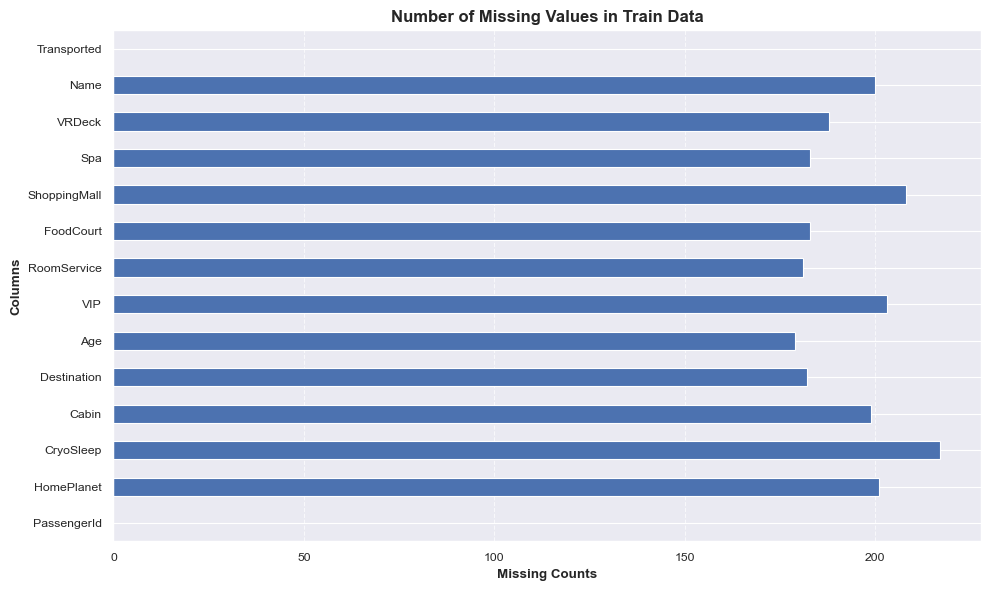

              MissingCount  MissingPercentage
PassengerId              0               0.00
HomePlanet             201               2.31
CryoSleep              217               2.50
Cabin                  199               2.29
Destination            182               2.09
Age                    179               2.06
VIP                    203               2.34
RoomService            181               2.08
FoodCourt              183               2.11
ShoppingMall           208               2.39
Spa                    183               2.11
VRDeck                 188               2.16
Name                   200               2.30
Transported              0               0.00


In [24]:
# missing values on train data
missing_data(train_data, plot=True,
             title="Number of Missing Values in Train Data")

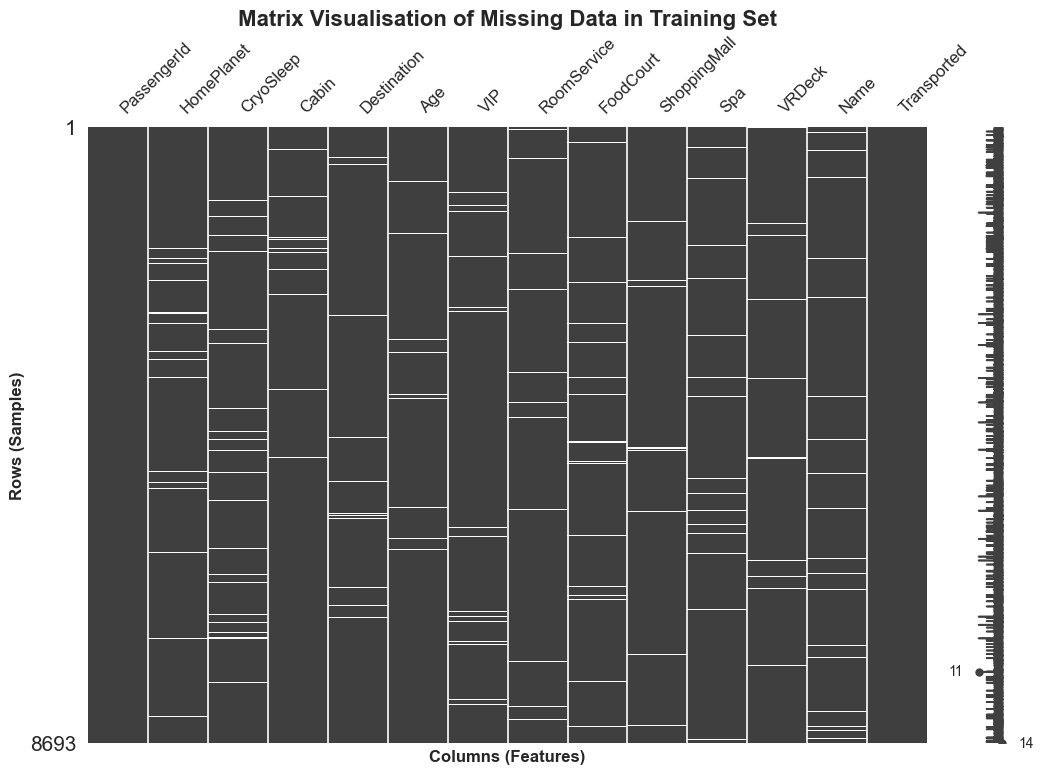

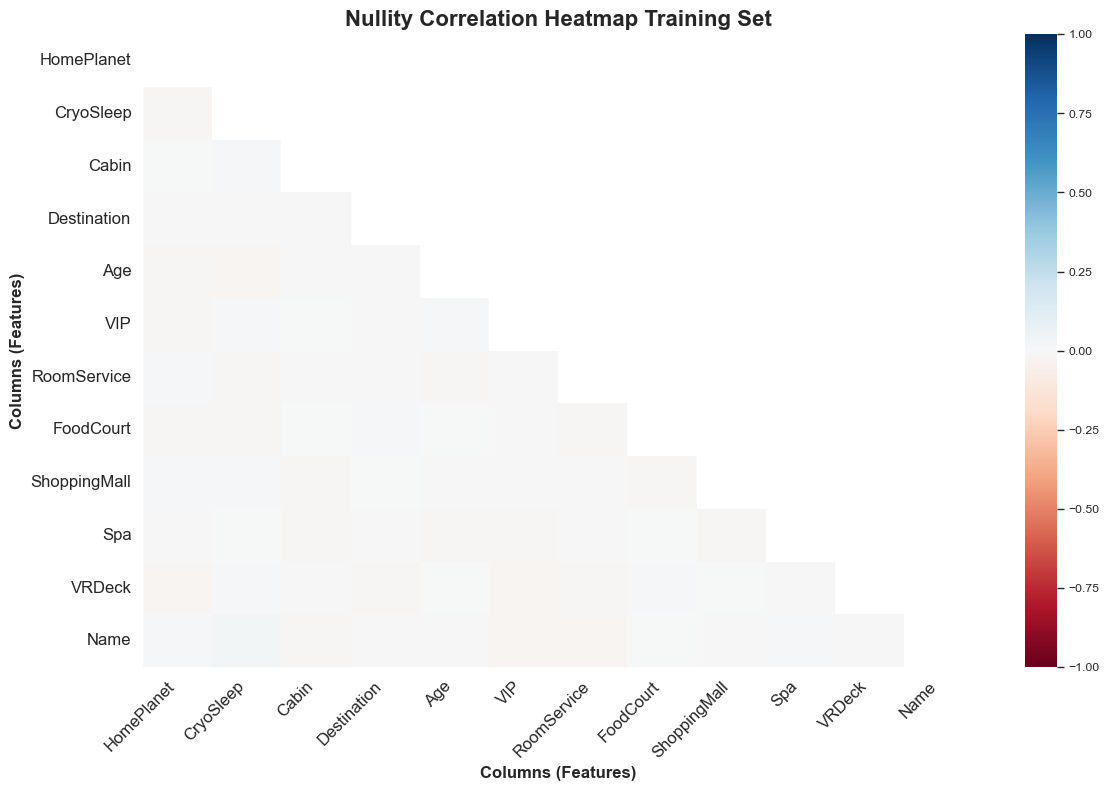

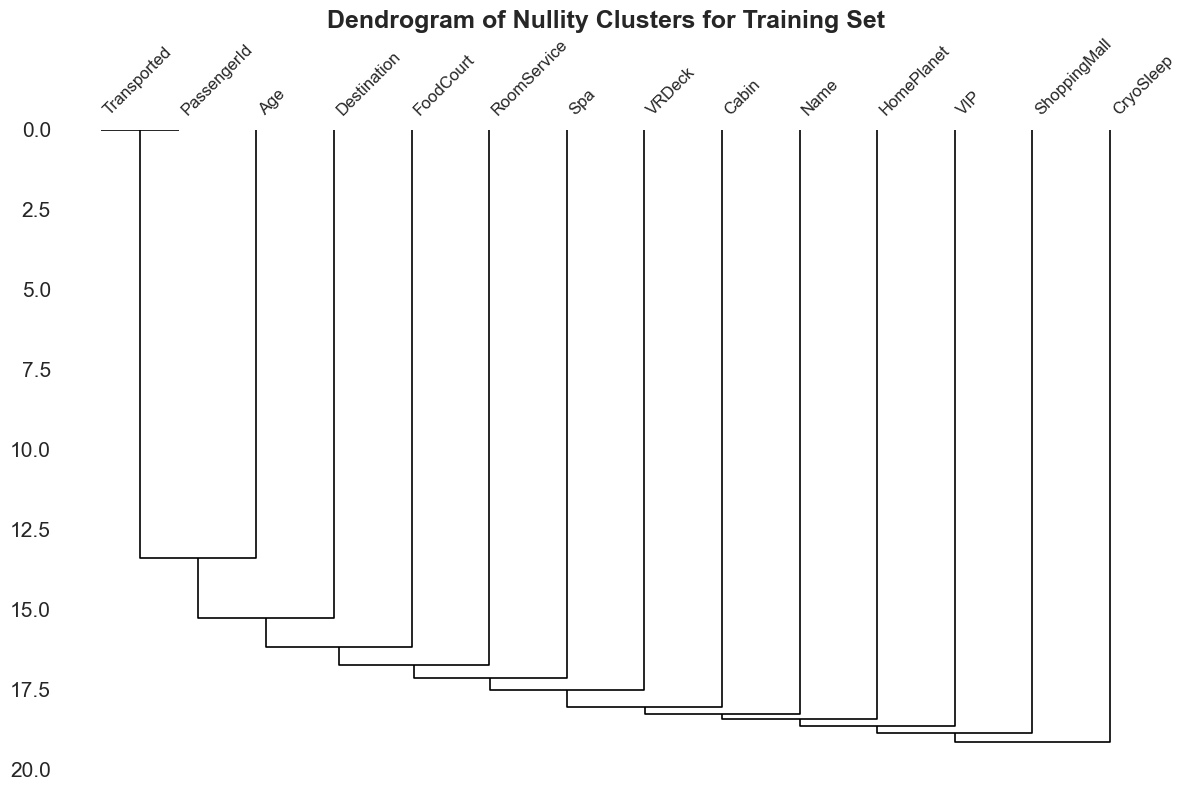

In [25]:
# visualising the missing data
missing_data_visualisation(train_data)

**Image-1: Matrix Visualisation of Missing Data in Training Set**
- **Systematic missingness:** Several features show consistent missing data patterns across rows
- Age appears to have substantial missing values
- CryoSleep and Cabin also show notable gaps
- The white lines indicate missing values, and their patterns suggest the missingness might not be completely random

**Image-2: Nullity Correlation Heatmap Training Set**
- Very weak correlations overall - most values appear close to 0 (light colors)
- No strong positive or negative correlations between features
- This suggests the features are largely independent, which could be good for modeling but might indicate limited predictive relationships
- The uniform light coloring indicates need for feature engineering to create more meaningful relationships

**Image-3: Dendrogram of Nullity Clusters for Training Set**
- **Left cluster:** Transported, PassengerId, Age, Destination - possibly demographic/booking info
- **Middle cluster:** FoodCourt, RoomService, Spa, VRDeck - clearly the amenity spending features
- **Right cluster:** Cabin, Name, HomePlanet, VIP, ShoppingMall, CryoSleep - mixed passenger characteristics

##### Test Dataset

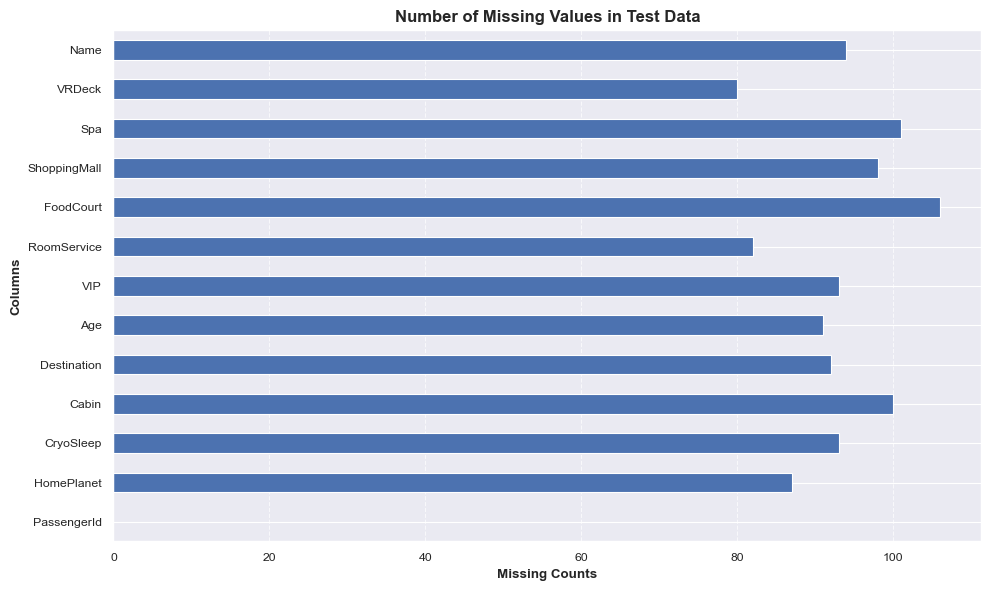

              MissingCount  MissingPercentage
PassengerId              0               0.00
HomePlanet              87               2.03
CryoSleep               93               2.17
Cabin                  100               2.34
Destination             92               2.15
Age                     91               2.13
VIP                     93               2.17
RoomService             82               1.92
FoodCourt              106               2.48
ShoppingMall            98               2.29
Spa                    101               2.36
VRDeck                  80               1.87
Name                    94               2.20


In [26]:
# missing values on train data
missing_data(test_data, plot=True,
             title="Number of Missing Values in Test Data")

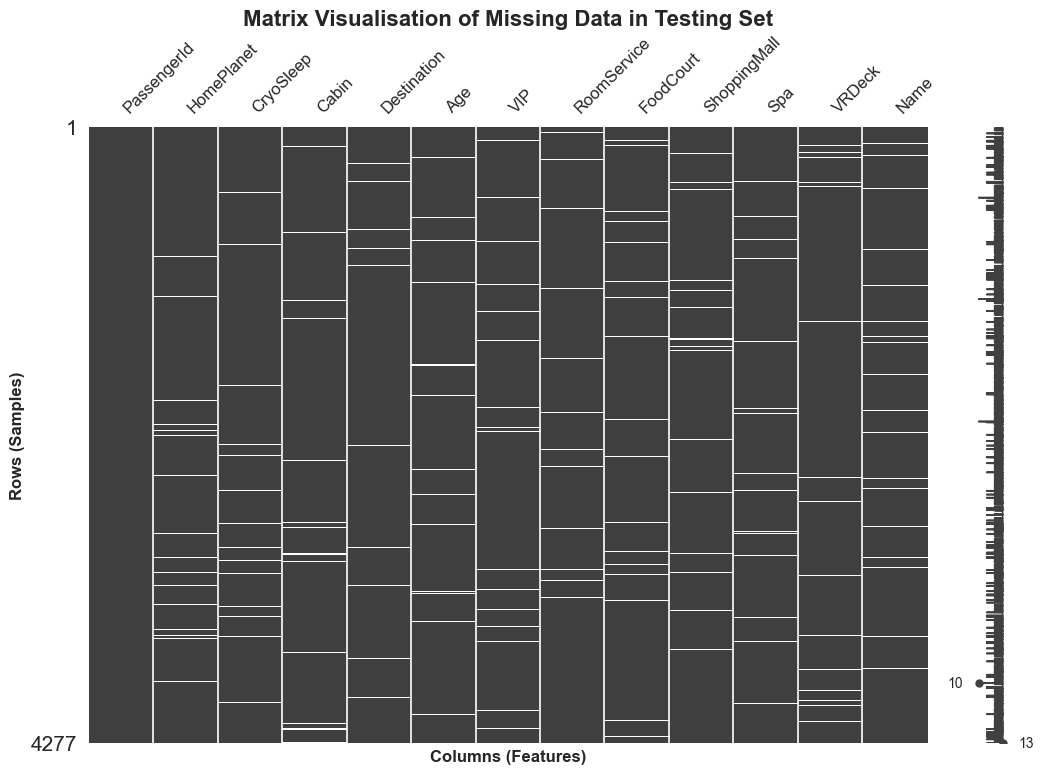

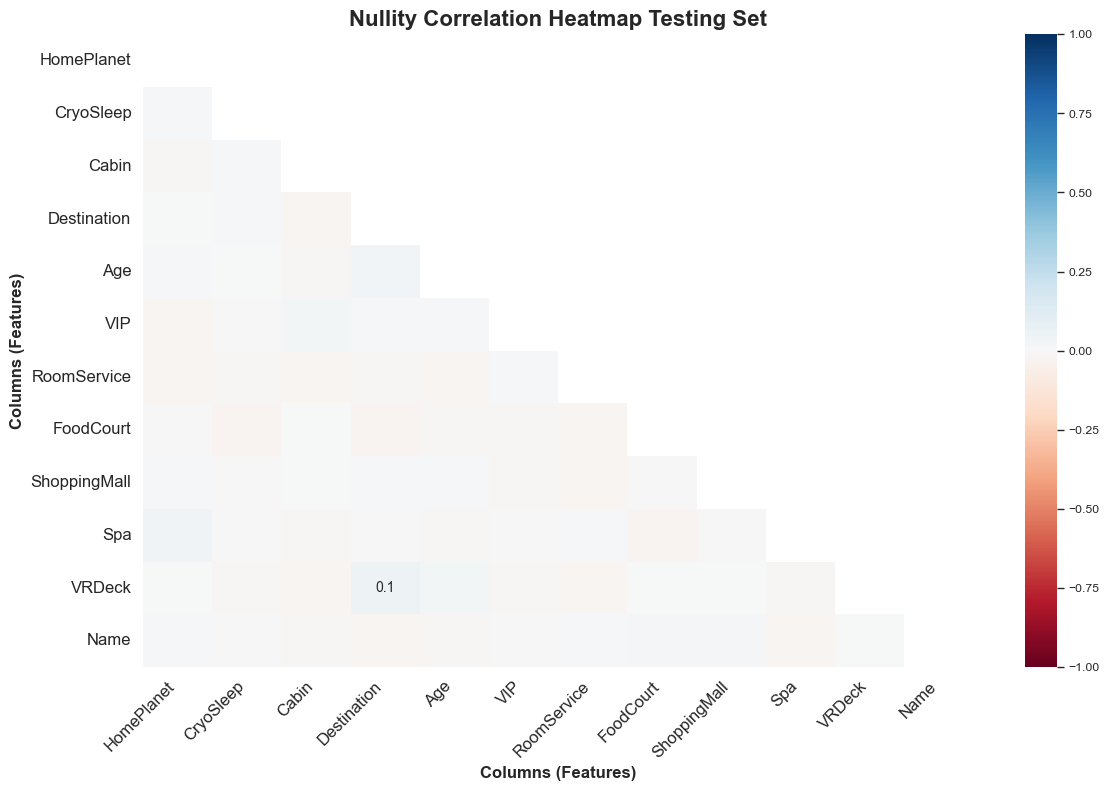

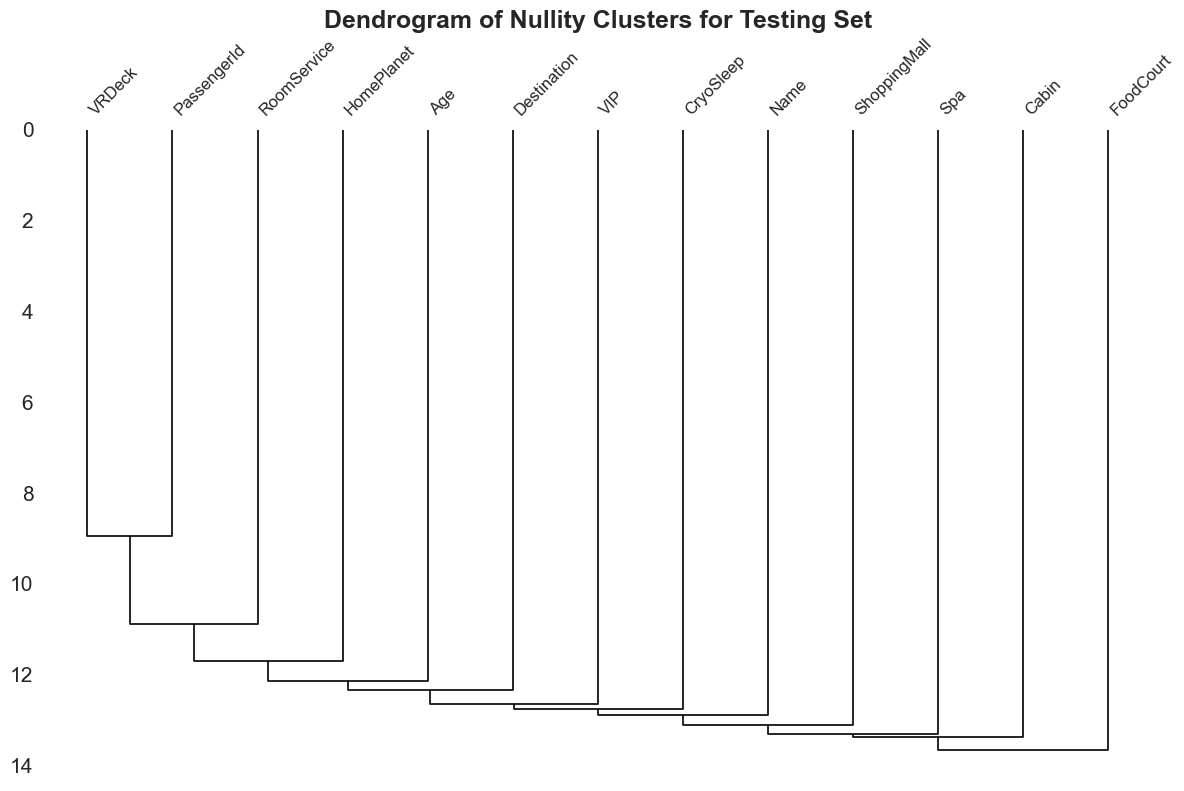

In [27]:
# visualising the missing data
missing_data_visualisation(test_data, title="Testing")

**Image-1: Matrix Visualisation of Missing Data in Testing Set**
- Overall missing data distribution appears consistent
- The missing data patterns in the test set closely mirror those in the training set, which is good for model generalization, meaning imputation strategies developed on training data should work well on test set.

**Image-2: Nullity Correlation Heatmap Testing Set**
- **Slightly stronger correlations visible:** The test set shows some slightly more pronounced relationships (though still weak overall)
- VRDeck shows a visible correlation value (0.1) with Destination - which wasn't as apparent in the training set
- Overall pattern consistency: The general weak correlation structure remains the same

**Image-3: Dendrogram of Nullity Clusters for Testing Set**
- **Different dendrogram structure:** The test set shows a completely different hierarchical clustering pattern
- **New groupings emerge:**
    - VRDeck now clusters separately at the left
    - Passenger demographic features (PassengerId, RoomService, HomePlanet, Age, Destination, VIP) form a large middle cluster
    - Amenity features (CryoSleep, Name, ShoppingMall, Spa, Cabin, FoodCourt) cluster on the right

NOTE: Models which can handle slight distribution shifts should be utilized for training, as the test and train data seems have different clustering patterns.

**Why it's MCAR:**
- All missing rates are nearly identical: 2.06% - 2.50% (only 0.44% difference)
- No logical pattern: Demographics, spending, and personal info all have ~2.2% missing - completely random
- Correlation heatmap shows ~0 correlations: Missing values don't predict other missing values

**Bottom line:** Missing rates are too uniform and random to be anything but **MCAR**. It's random data collection errors, not systematic patterns.

#### Class Balance Analysis

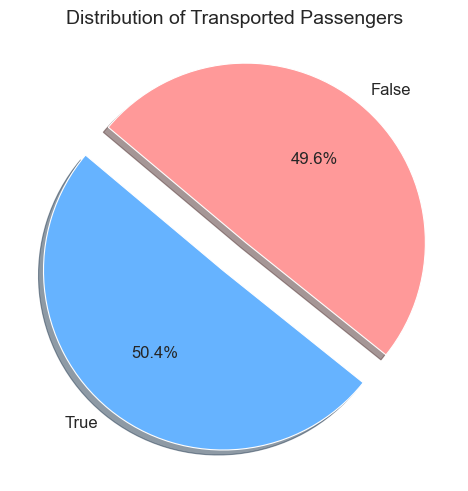

In [28]:
# Define plot style
fig, ax = plt.subplots(figsize=(5, 5))
colors = ["#66b3ff", "#ff9999"]

# Plot pie chart
train_data["Transported"].value_counts().plot.pie(
    explode=(0.1, 0.1),
    autopct='%1.1f%%',
    shadow=True,
    startangle=140,
    colors=colors,
    textprops={"fontsize": 12},
    ax=ax
)  # type: ignore

ax.set_ylabel("")
ax.set_title("Distribution of Transported Passengers", fontsize=14)
plt.tight_layout()
plt.show()

- **Nearly perfect balance:**
    - Transported -- True: 50.4%
    - Transported -- False: 49.6%
- Standard accuracy metrics are reliable - precisions, recall, and f1-score will be meaningful
- Stable model training 
- Consistent cross-validation results - balanced spilt will maintain this distribution
- **Evaluation Strategy:**
    - Standard train/validation/test splits can be used without worrying about stratification
    - ROC-AUC will be a particularly good metric given the balanced classes
    - Confusion matrices will be easily interpretable

#### Column Extraction Based on Datatype

In [29]:
# getting the numerical columns
numerical_features = train_data.select_dtypes(
    include=[np.number]).columns.tolist()
# getting the categorial columns
categorical_features = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
# getting the qualitative columns
qualitative_features = ["PassengerId", "Cabin", "Name"]

#### Numerical Features Analysis

##### Features Distribution

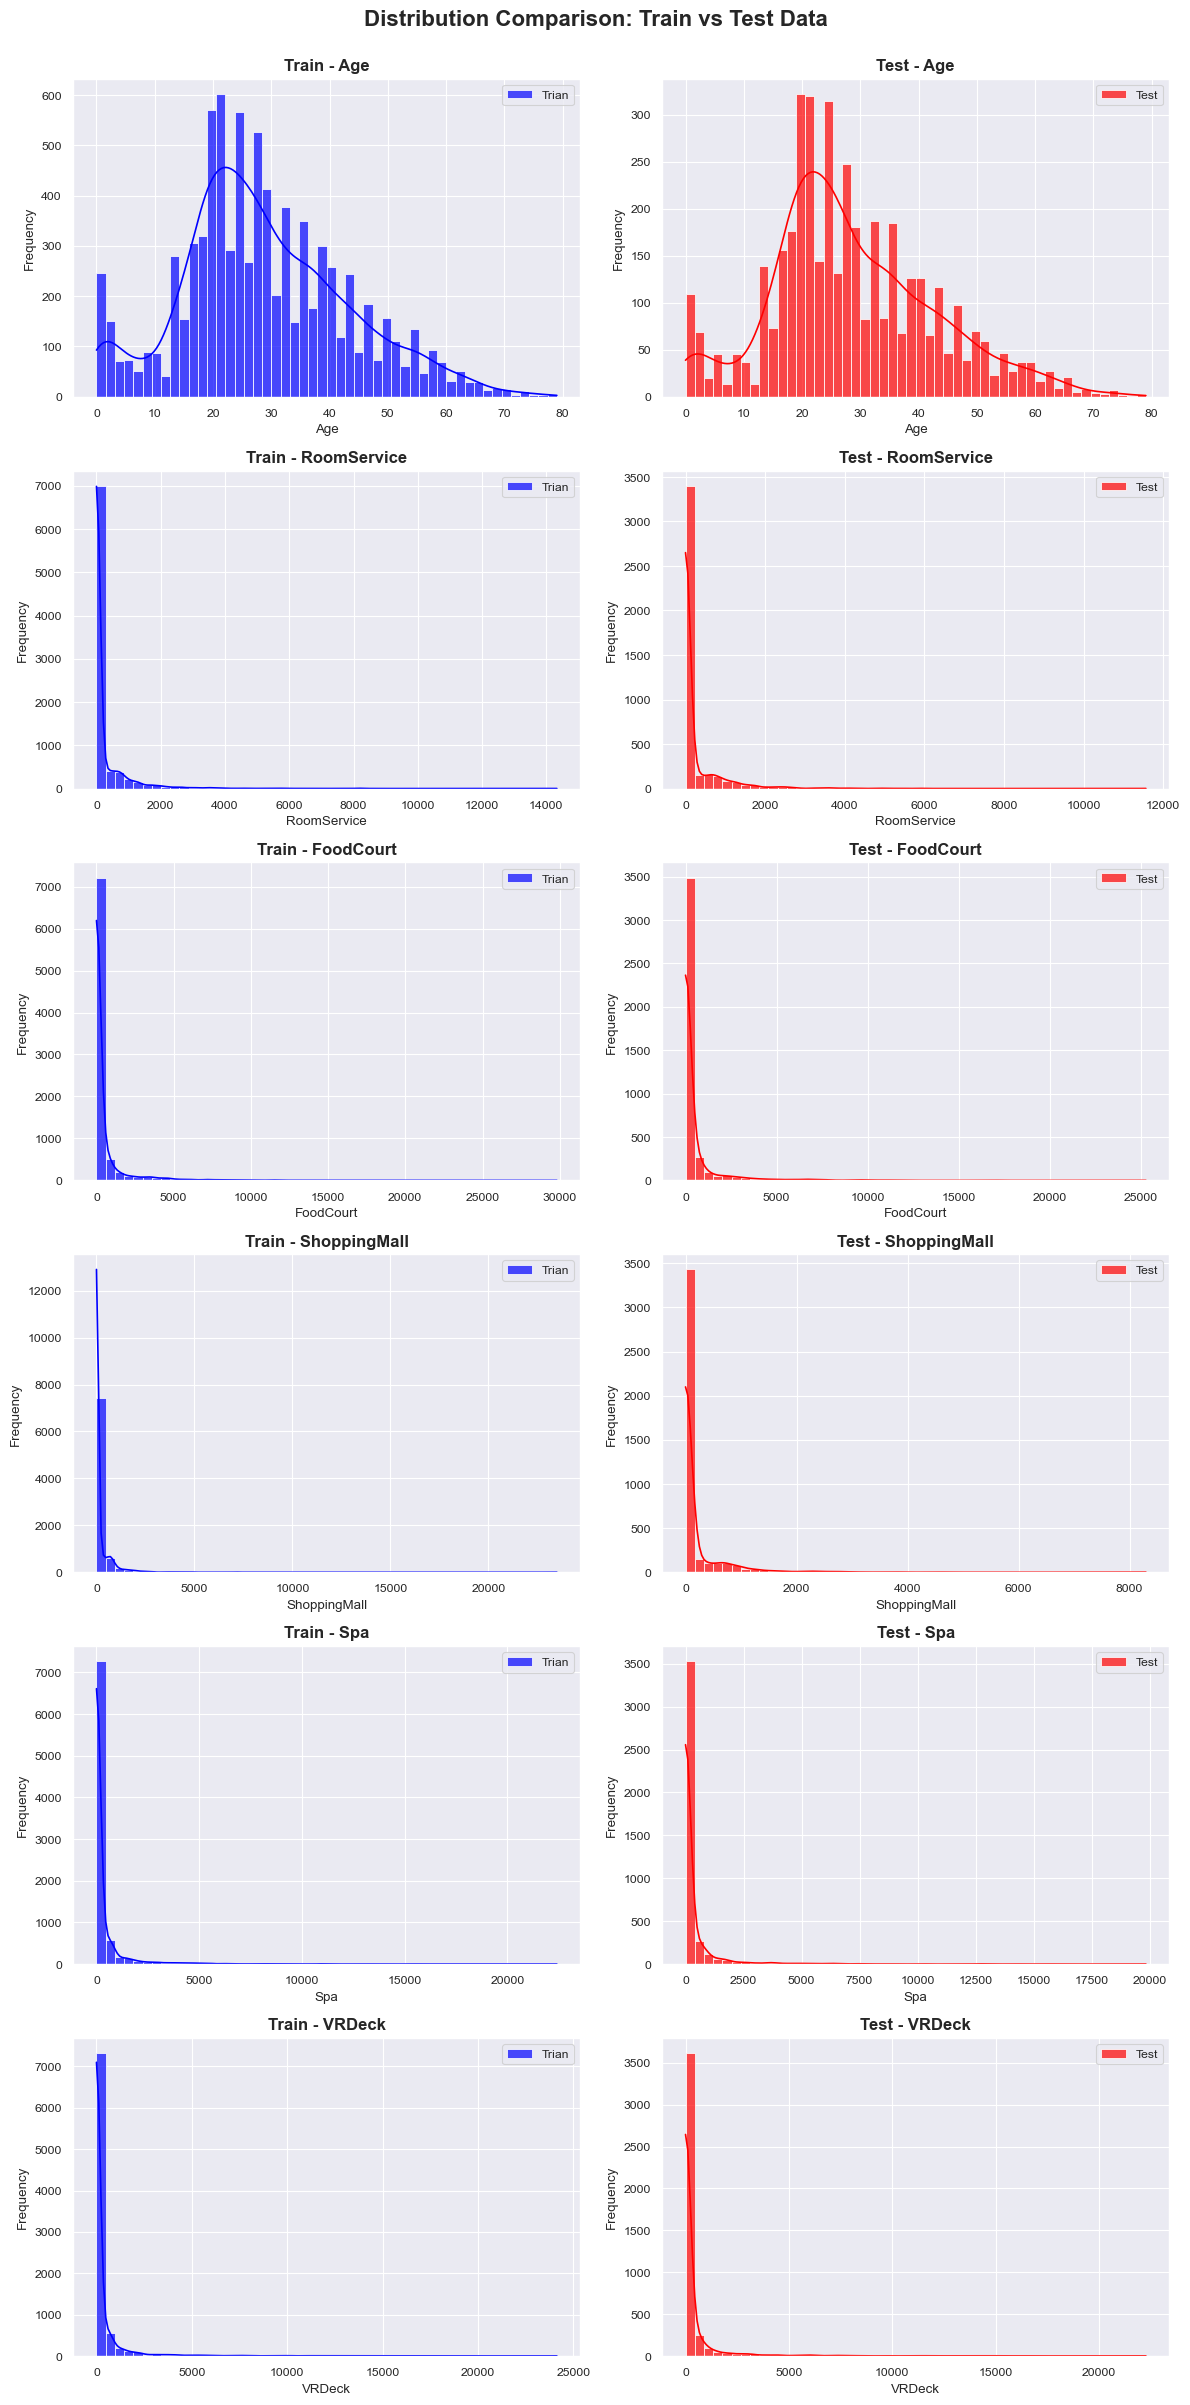

In [30]:
# Create subplots: rows = number of numerical features, 2 columns (train/test)
fig, axs = plt.subplots(len(numerical_features), 2,
                        figsize=(12, 4*len(numerical_features)))

# Loop through each numerical feature to create distribution plots
for i, col in enumerate(numerical_features):
    # Train plot (left column) - histogram with kde overlay
    sns.histplot(data=train_data, x=col, kde=True, ax=axs[i, 0],
                 color="blue", alpha=0.7, bins=50, label="Trian")
    axs[i, 0].set_title(f"Train - {col}", fontweight="bold", fontsize=12)
    axs[i, 0].set_ylabel("Frequency")
    axs[i, 0].legend()

    # Test plot (right column) - histogram with kde overlay
    sns.histplot(data=test_data, x=col, kde=True, ax=axs[i, 1],
                 color="red", alpha=0.7, bins=50, label="Test")
    axs[i, 1].set_title(f"Test - {col}", fontweight="bold", fontsize=12)
    axs[i, 1].set_ylabel("Frequency")
    axs[i, 1].legend()
# Add overall title to the figure
fig.suptitle("Distribution Comparison: Train vs Test Data",
             fontsize=16, fontweight="bold", y=1)
plt.tight_layout()
plt.savefig(
    os.path.join(
        image_save_path, "Distribution Comparison Train vs Test Data.png"),
    bbox_inches="tight")
plt.show()

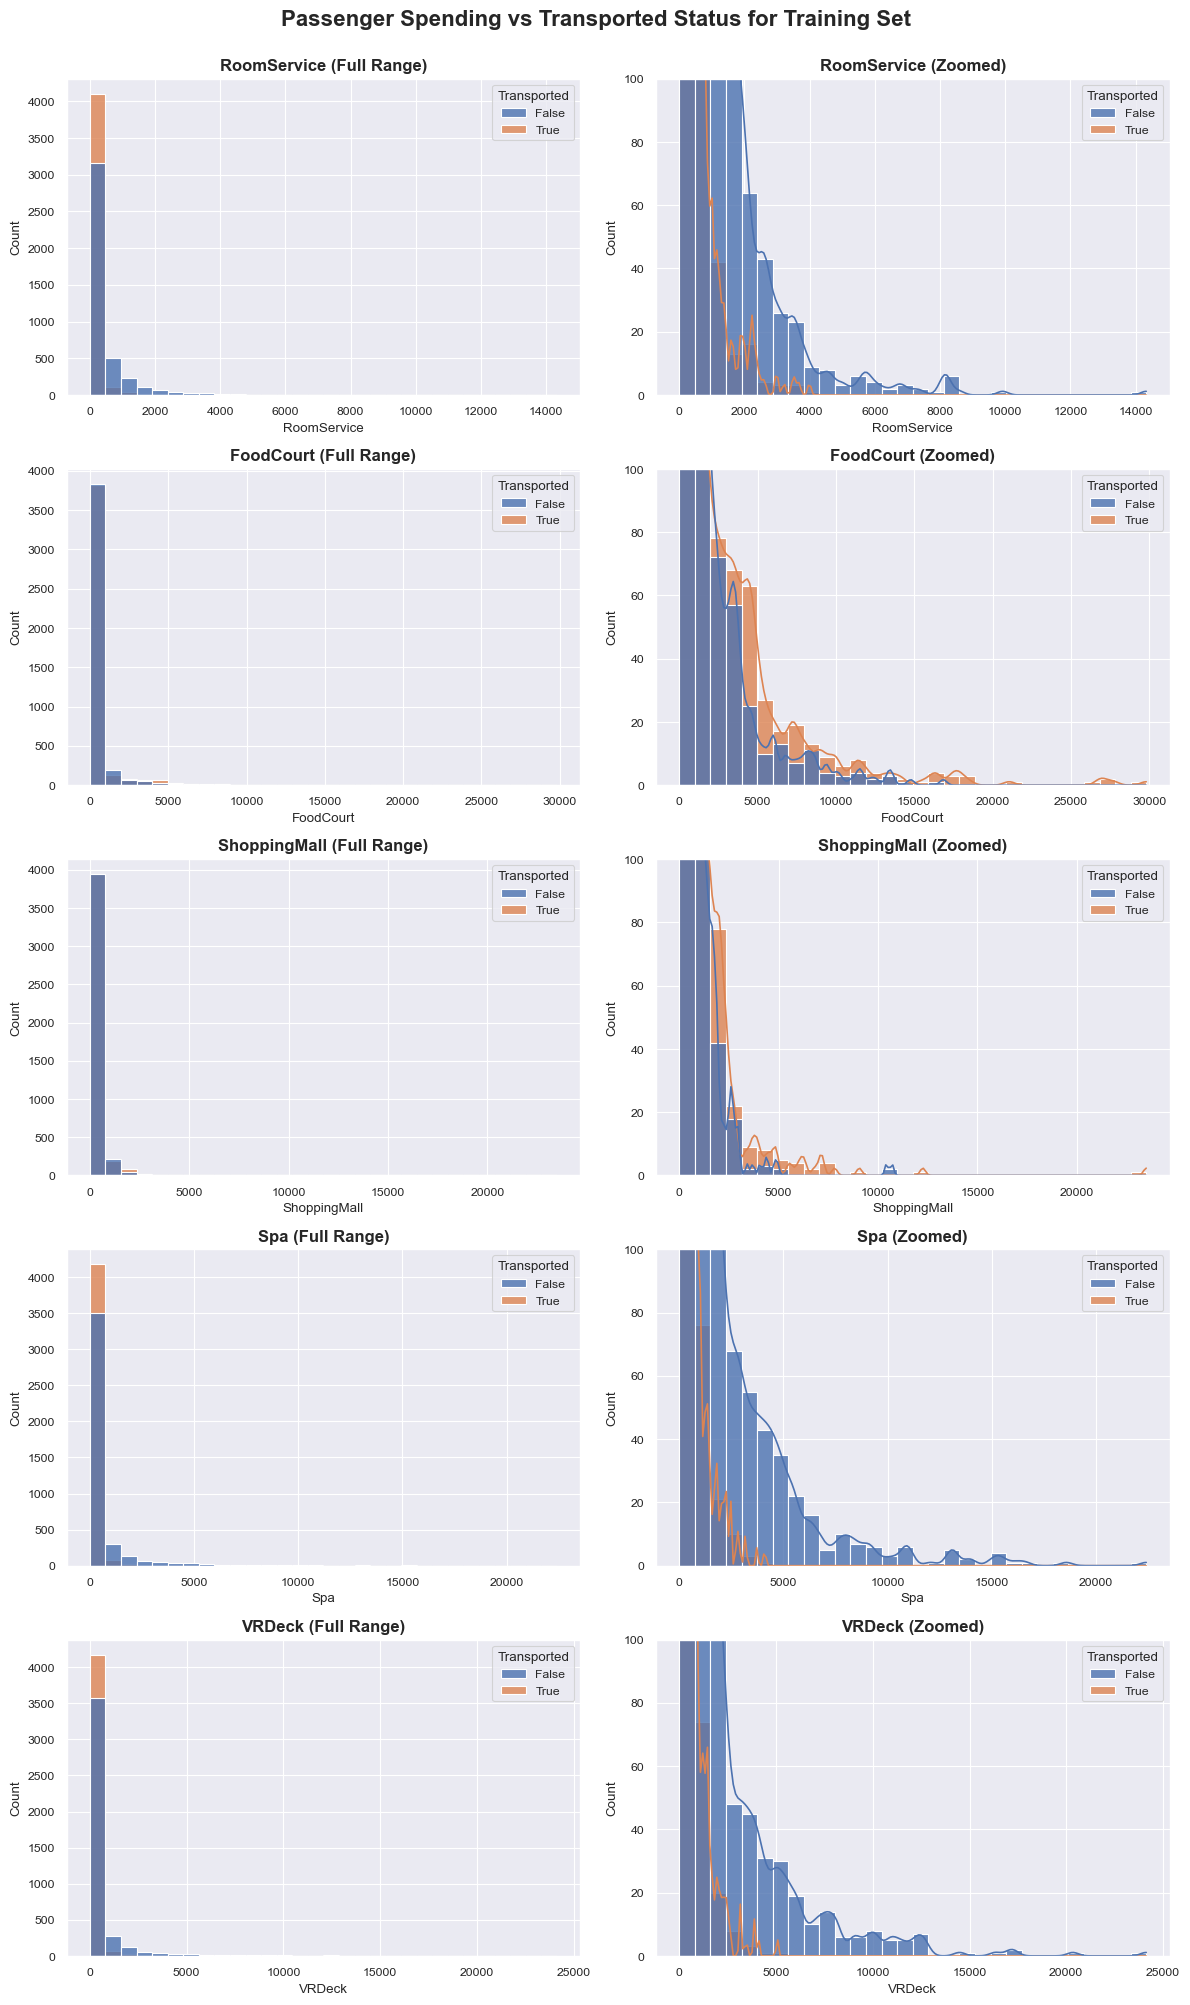

In [31]:
# Define expenditure-related columns
spending_features = ['RoomService', 'FoodCourt',
                     'ShoppingMall', 'Spa', 'VRDeck']

# Create figure
fig, axes = plt.subplots(nrows=len(spending_features),
                         ncols=2, figsize=(12, 20))
fig.suptitle("Passenger Spending vs Transported Status for Training Set",
             fontsize=16, fontweight="bold", y=1)

# Loop over each feature
for idx, feature in enumerate(spending_features):
    # Left: full distribution
    sns.histplot(
        data=train_data,
        x=feature,
        hue='Transported',
        ax=axes[idx, 0],
        bins=30,
        kde=False,
        alpha=0.8
    )
    axes[idx, 0].set_title(f"{feature} (Full Range)",
                           fontsize=12, fontweight="bold")

    # Right: zoomed-in distribution
    sns.histplot(
        data=train_data,
        x=feature,
        hue='Transported',
        ax=axes[idx, 1],
        bins=30,
        kde=True,
        alpha=0.8
    )
    axes[idx, 1].set_ylim(0, 100)
    axes[idx, 1].set_title(f"{feature} (Zoomed)",
                           fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig(
    os.path.join(
        image_save_path,
        "Passenger Spending vs Transported Status for Training Set.png"),
    bbox_inches="tight")
plt.show()

**Key Observations** [From both the Graphs]
- **Age Distribution:**
    - Both datasets show similar patterns: Normal-like distribution with peak around 25-30 years
    - Good consistency: Train and test distributions are well-aligned
    - Range: Both span 0-80 years with similar frequency patterns
    - Positive sign: No significant distribution shift between train/test
- **Spending Features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck):**
    - Highly right-skewed: All show extreme concentration at zero
    - Zero-inflation problem: Vast majority of passengers spend $0 on these amenities
    - Long tail: Few passengers with high spending create extreme outliers
    - Consistent pattern: All spending features follow similar distributions

##### Outlier Detection
Uses box plot to visual/detect outliers from numerical features.

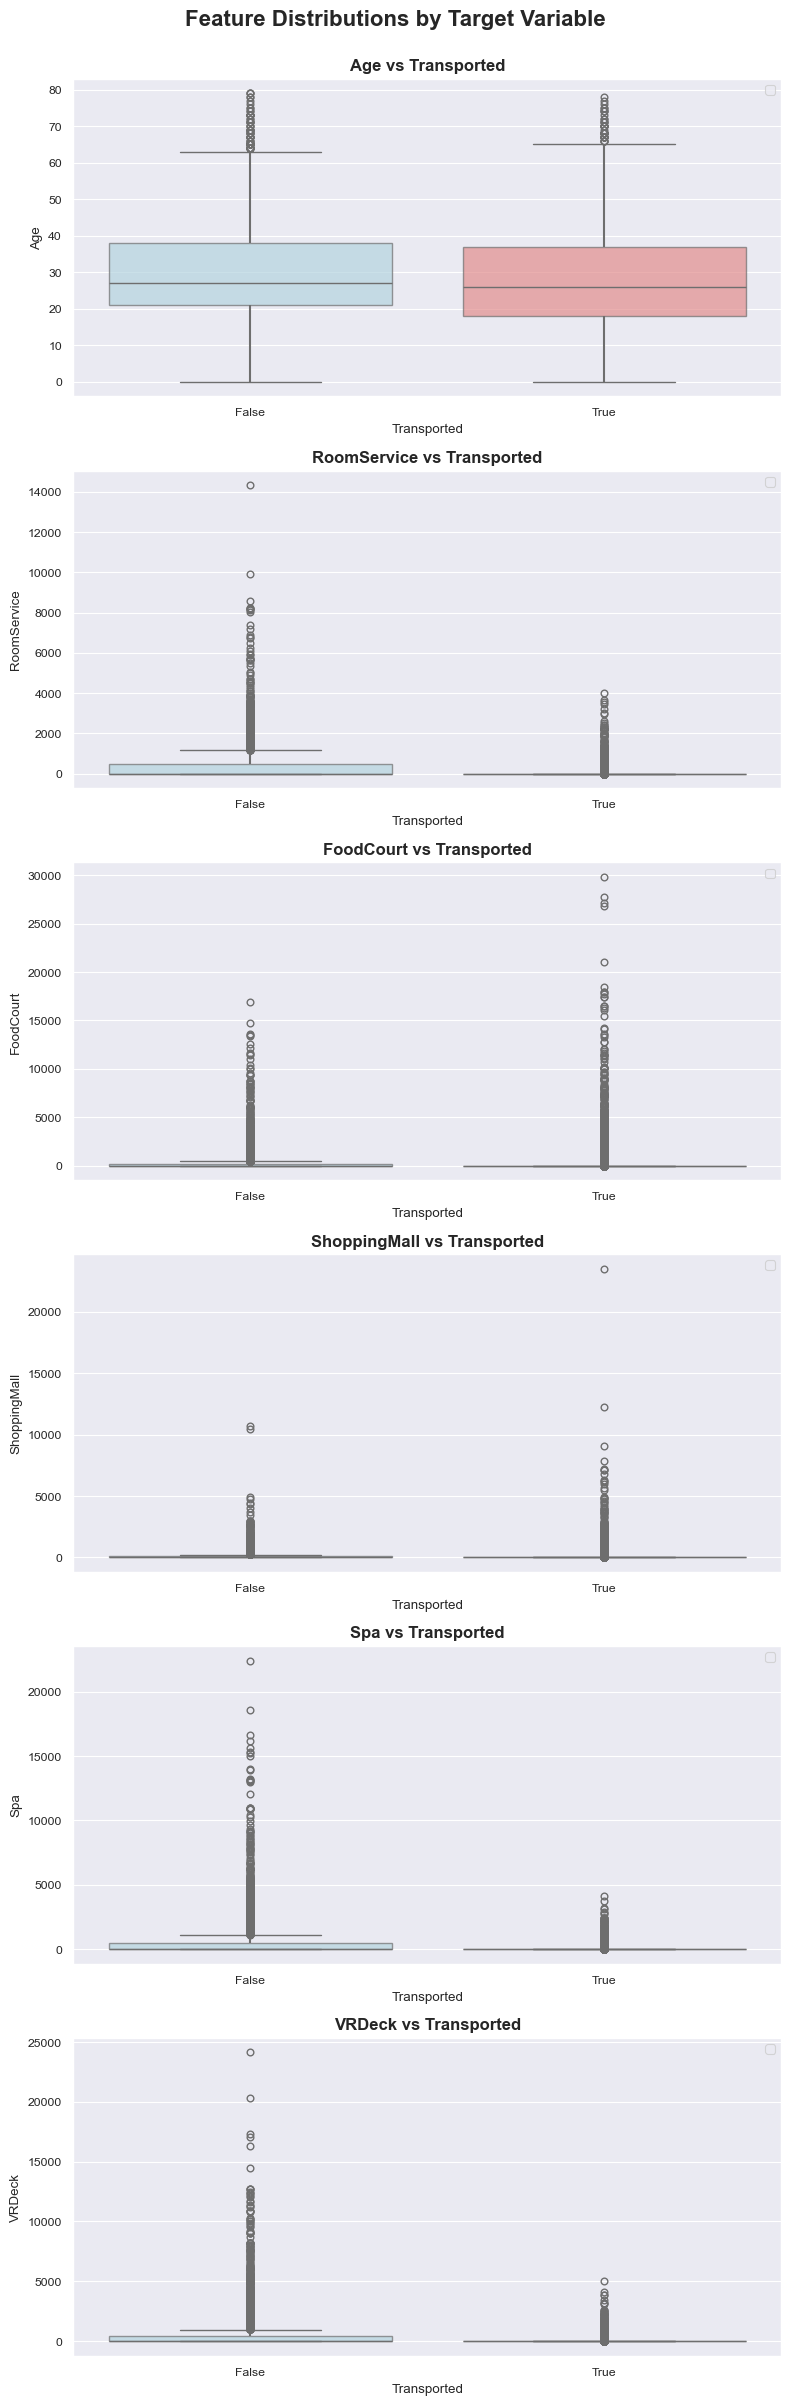

In [32]:
# Create subplots: rows = number of numerical features, 1 columns
fig, axs = plt.subplots(len(numerical_features), 1,
                        figsize=(8, 4*len(numerical_features)))

# Loop through each numerical feature to create distribution plots
for i, col in enumerate(numerical_features):
    # Create boxplot with the numerical col and transported
    sns.boxplot(data=train_data, x="Transported", y=col, ax=axs[i],
                palette=["lightblue", "lightcoral"],
                boxprops={"alpha": 0.7},
                whiskerprops={"linewidth": 1.5})
    axs[i].set_title(f"{col} vs Transported", fontweight="bold", fontsize=12)
    axs[i].legend()

# Add overall title to the figure
fig.suptitle("Feature Distributions by Target Variable",
             fontsize=16, fontweight="bold", y=1)
plt.tight_layout()
plt.savefig(
    os.path.join(
        image_save_path, "Feature Distributions by Target Variable.png"),
    bbox_inches="tight")
plt.show()

**Key Observations:**
- **Age Distribution**
    - Very similar distributions between transported and non-transported passengers
    - Both groups have median ages around 27-30 years
    - Similar interquartile ranges and outlier patterns
    - Age appears to have minimal predictive power for transportation outcome

- **Spending Features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)**
    - All spending features show a consistent and striking pattern:
    - **Non-Transported (False) passengers:**
        - Extremely high spending across all amenities
        - Multiple high-value outliers
        - Higher median spending in all categories
        - Wide distribution of spending amounts

    - **Transported (True) passengers:**
        - Minimal to zero spending across all amenities
        - Very low medians
        - Few outliers, and when present, much lower values
        - Highly concentrated near zero spending

##### Feature Interactions by Transportation Status

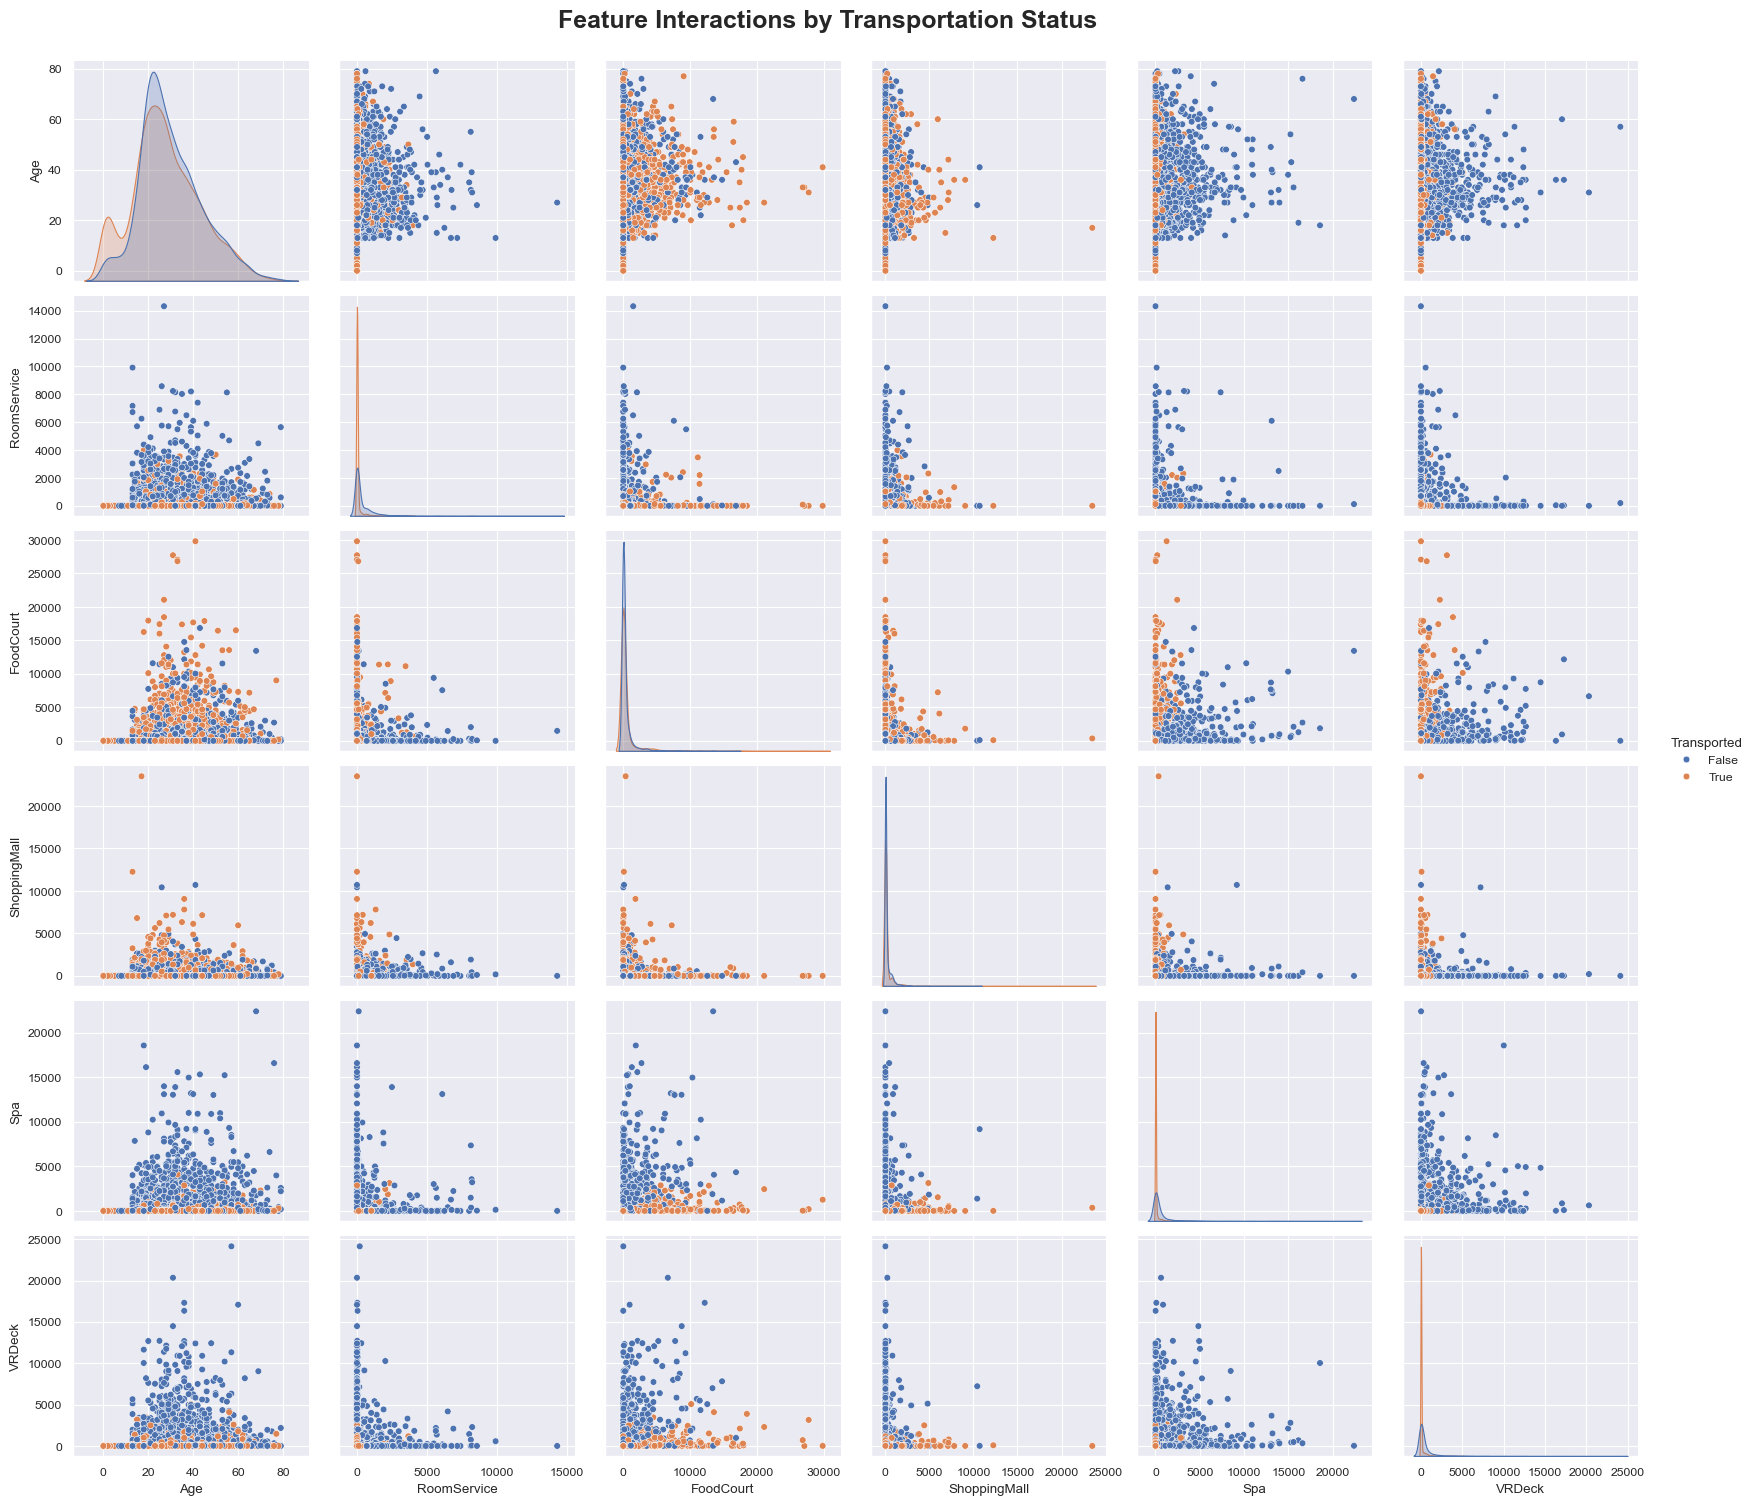

In [33]:
# pairplot for numberical features by transported
g = sns.pairplot(data=train_data, vars=numerical_features, hue="Transported")
# Move legend outside the plot
g._legend.remove()  # type: ignore # Remove the default legend
g.add_legend(title="Transported",
             bbox_to_anchor=(1, 0.5),  # Position outside plot area
             loc="center left")
# add overall title to the figure
plt.suptitle("Feature Interactions by Transportation Status",
             fontsize=18, fontweight="bold", y=1)
plt.tight_layout()
# saving the plot
plt.savefig(os.path.join(image_save_path,
            "Feature Interactions by Transportation Status.png"),
            bbox_inches="tight")
plt.show()

**Feature Relationships & Patterns:**
1. **Age Distribution & Relationships:**
    - Age shows a normal distribution (diagonal histogram)
    - Age has weak correlations with all spending features
    - Age shows minimal separation between transported (blue) and non-transported (orange) passengers
    - Confirms age is not a strong predictor

2. **Spending Feature Patterns:**
    - All spending features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) show highly   right-skewed distributions
    - Most passengers spend 0-2000, with extreme outliers spending 10k-30k+
    - Strong positive correlations between all spending features - passengers who spend on one amenity tend to spend on others

3. **Class Separation:**
    - Excellent class separation visible in all scatter plots
    - Orange points (False/not transported) cluster in higher spending regions
    - Blue points (True/transported) concentrate near zero spending across all features
    - The separation is so clear it suggests these will be highly predictive features

4. **Feature Interactions:**
    - Multicollinearity evident among spending features - they move together
    - Create composite spending variables or using dimensionality reduction
    - The spending patterns suggest different passenger behavioral profiles

##### Composite Spending Variable
TotalSpend variable created to track overall spending.

In [34]:
# Define list of spending-related features
spending_columns = ['RoomService', 'FoodCourt',
                    'ShoppingMall', 'Spa', 'VRDeck']

# Add new features to both train and test sets
for df in [train_data, test_data]:
    df['TotalSpend'] = df[spending_columns].sum(axis=1)
    df['NoSpendFlag'] = (df['TotalSpend'] == 0).astype(int)

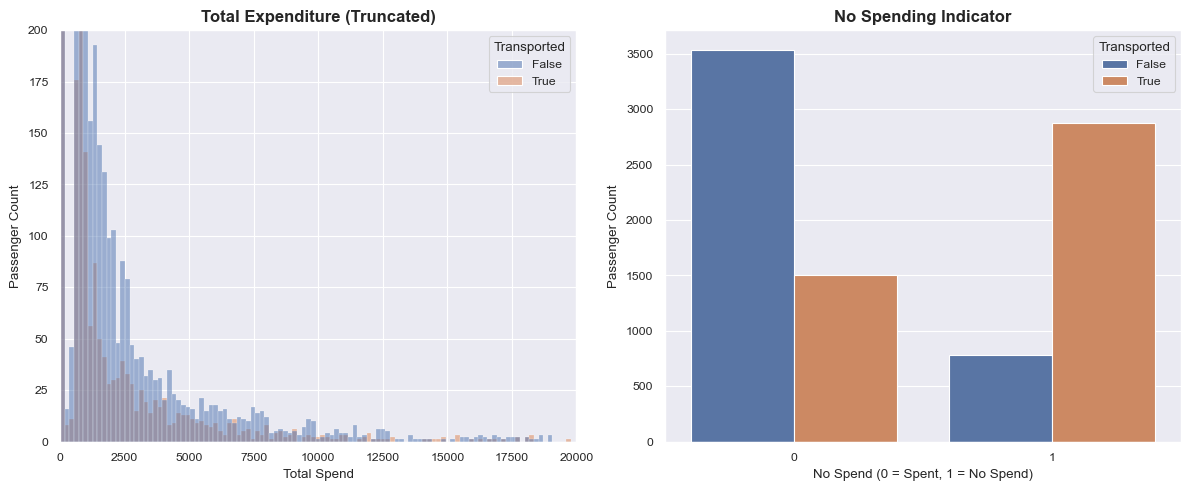

In [35]:
# defining the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Distribution of Total Spend
sns.histplot(
    data=train_data,
    x='TotalSpend',
    hue='Transported',
    bins=200,
    ax=axes[0]
)
axes[0].set_title('Total Expenditure (Truncated)',
                  fontsize=12, fontweight="bold")
axes[0].set_xlim(0, 20000)
axes[0].set_ylim(0, 200)
axes[0].set_xlabel("Total Spend")
axes[0].set_ylabel("Passenger Count")

# Right: Binary Spending Indicator
sns.countplot(
    data=train_data,
    x='NoSpendFlag',
    hue='Transported',
    ax=axes[1]
)
axes[1].set_title('No Spending Indicator', fontsize=12, fontweight="bold")
axes[1].set_xlabel("No Spend (0 = Spent, 1 = No Spend)")
axes[1].set_ylabel("Passenger Count")

plt.tight_layout()
plt.savefig(os.path.join(image_save_path,
                         "Total Expenditure vs No spending indicator.png"),
            bbox_inches="tight")
plt.show()

**1. Total Expenditure Distribution (Left Plot):**
- The distribution shows a natural spending threshold around 2,500
- Very few transported passengers spend above this threshold
- Non-transported passengers show much more varied spending patterns
- Extreme high spenders (>10,000) are almost exclusively non-transported

**2. No Spending Indicator (Right Plot):**
- Non-transported passengers mostly spend money (70%), while transported passengers mostly don't spend (78%)
- If a passenger spends$0, they have a 78% chance of being transported
- Passengers who spend money are 3.6 times more likely to not get transported

##### Assign Age into Groups
The age has been grouped into various caterogies:
  - 00–12 years
- 13–17 years
- 18–25 years
- 26–30 years
- 31–50 years
- 51+ years

In [36]:
# assign age groups to both train and test sets
train_data = assign_age_group(train_data)
test_data = assign_age_group(test_data)

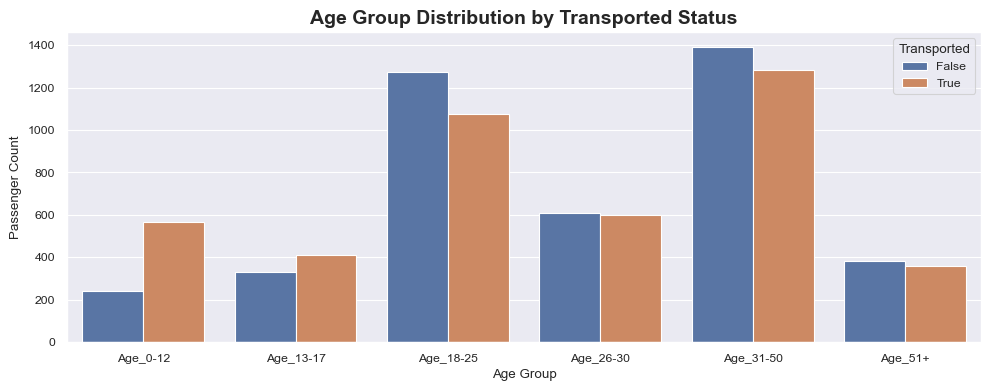

In [37]:
plt.figure(figsize=(10, 4))

sns.countplot(
    data=train_data,
    x='AgeGroup',
    hue='Transported',
    order=['Age_0-12', 'Age_13-17', 'Age_18-25',
           'Age_26-30', 'Age_31-50', 'Age_51+']
)

plt.title('Age Group Distribution by Transported Status',
          fontsize=14, fontweight="bold")
plt.xlabel('Age Group')
plt.ylabel('Passenger Count')
plt.tight_layout()
plt.savefig(os.path.join(image_save_path,
                         "Age Group Distribution by Transported Status.png"),
            bbox_inches="tight")
plt.show()

**1. Children Are More Likely to be Transported:**
- Age 0-12 group shows 70% transported vs 30% not transported - the strongest bias toward transportation.

**2. Young Adults Favor Staying on Ship**
- Age 18-25 group has more non-transported passengers (1,300 vs 1,050), suggesting they prefer ship amenities.

**3. Middle-Aged Groups Show Balanced Patterns**
- Ages 26-30 and 31-50 have nearly equal transportation rates, making age less predictive for these groups.

**4. Seniors Have Slight Transportation Preference**
- Age 51+ group shows slightly more transported passengers, but the difference is minimal compared to children.

##### Correlation Plot

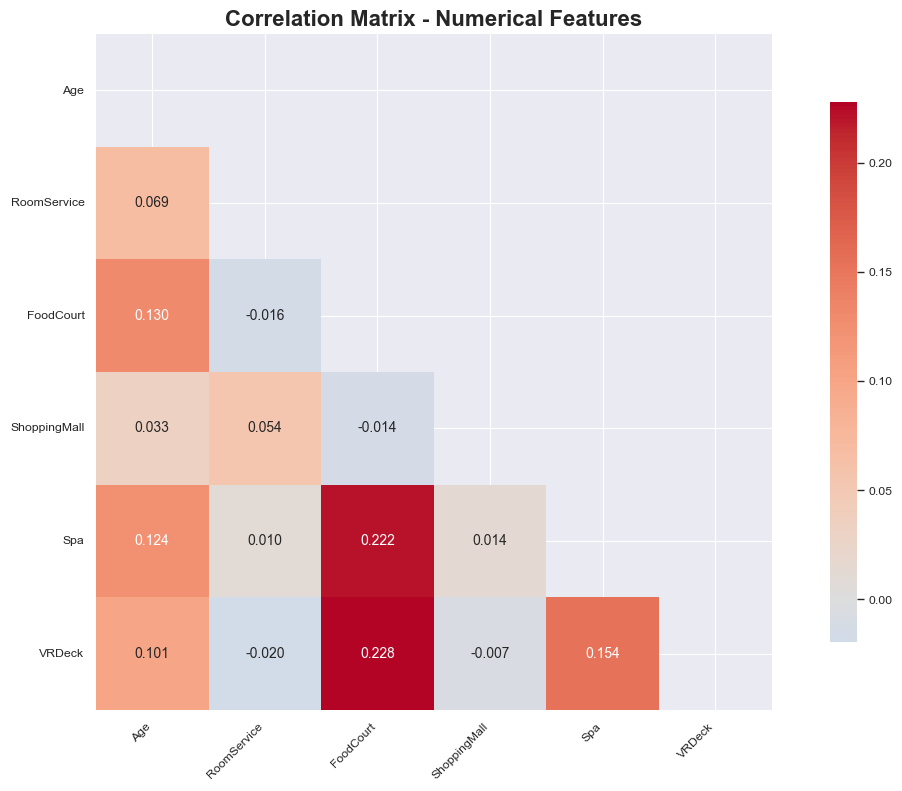

In [38]:
# correlation matrix for default numerical features
correlation_matrix_default_features = correlation_matrix_visualise(
    train_data, numerical_features, "Correlation Matrix - Numerical Features")

**Observations:**

**1. Weak Connections Between Spending**
- People who spend on one thing don't always spend on others - the connections are weak.

**2. Age Doesn't Matter for Spending**
- Older or younger passengers don't spend more or less money on amenities.

**3. Shopping and VR Are Most Related**
- People who shop are most likely to also use VR - but even this connection is weak.

**4. Each Feature Is Different**
- All features are independent enough to be useful separately in predictions.

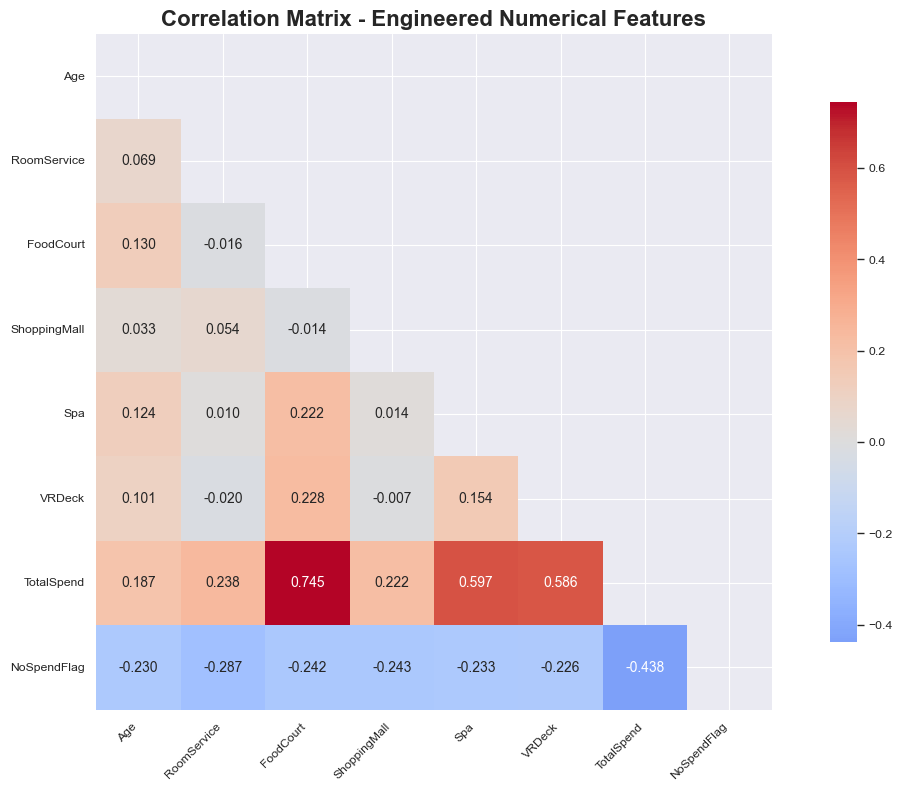

In [39]:
# correlation matrix for engineered numerical features
correlation_matrix_engineered_features = correlation_matrix_visualise(
    train_data, train_data.select_dtypes(include=[np.number]).columns.tolist(),
    "Correlation Matrix - Engineered Numerical Features")

**Key Changes After Feature Engineering:**

**1. Strong New Patterns:**
- **TotalSpend** shows strong correlations (0.745 with FoodCourt, 0.597 with Spa, 0.586 with VRDeck)
- **NoSpendFlag** shows clear negative relationships (-0.438 with TotalSpend)

**2. Original Features Unchanged:**
- All previous weak correlations remain the same

**3. Impact:**
- Engineered features reveal spending behavior patterns that individual features missed
- Will likely improve model performance by capturing overall spending vs. non-spending groups

#### Categorical Features Analysis

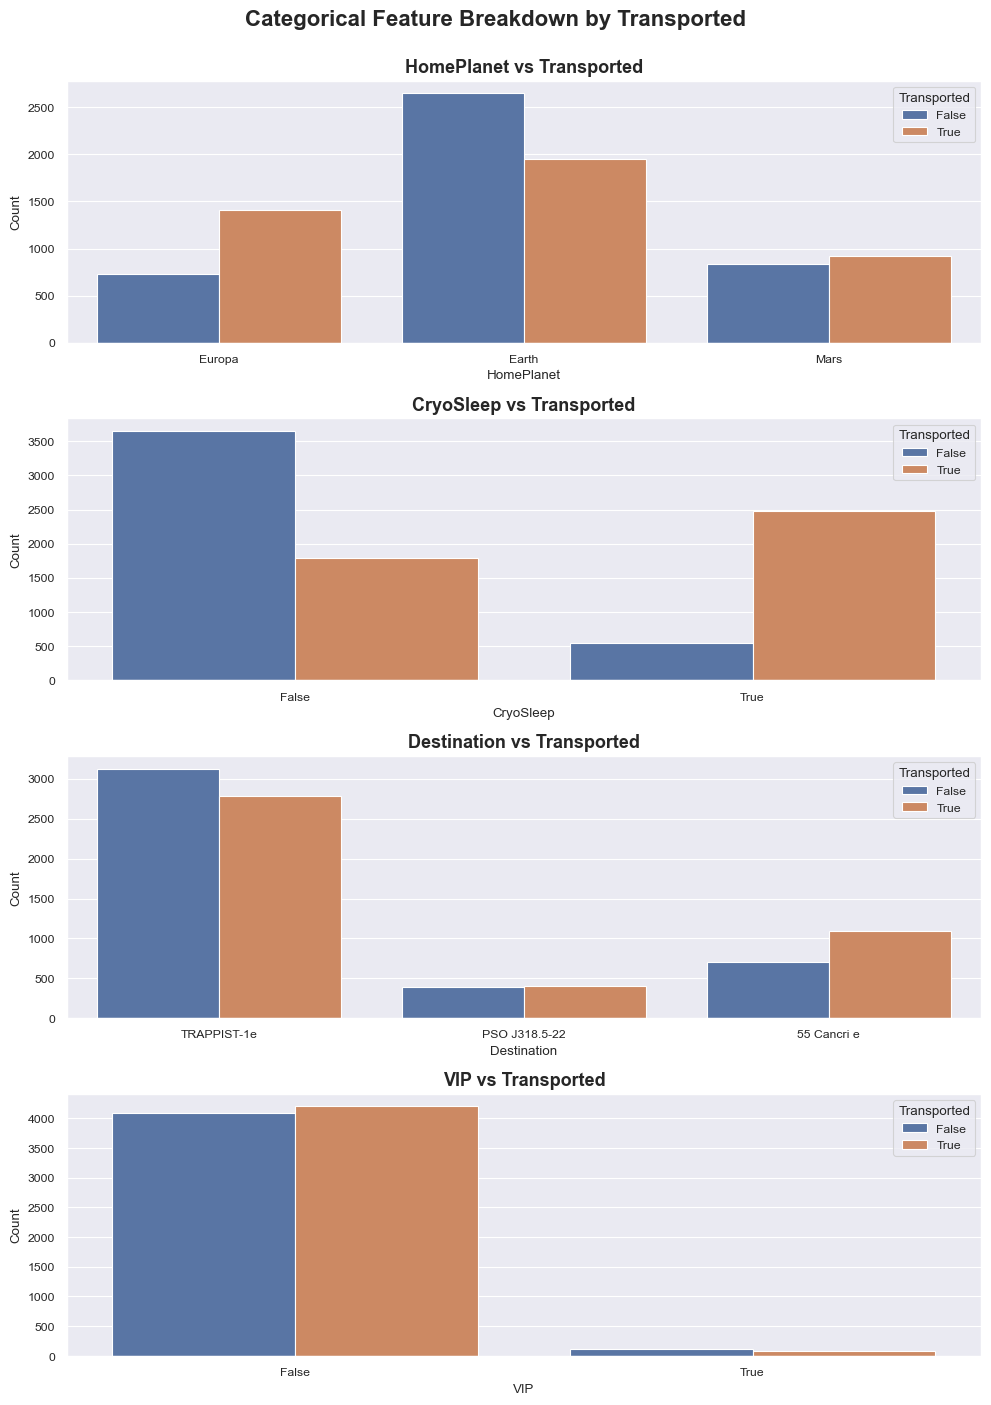

In [40]:
# Setup figure and axes
fig, axes = plt.subplots(
    nrows=len(categorical_features), ncols=1, figsize=(10, 14))
fig.suptitle("Categorical Feature Breakdown by Transported",
             fontsize=16, fontweight="bold", y=1)

# Plot each feature
for idx, col in enumerate(categorical_features):
    sns.countplot(
        data=train_data,
        x=col,
        hue='Transported',
        ax=axes[idx],
    )
    axes[idx].set_title(f"{col} vs Transported",
                        fontsize=13, fontweight="bold")
    axes[idx].set_ylabel("Count")
    axes[idx].set_xlabel(col)
    axes[idx].legend(title='Transported', loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(image_save_path,
                         "Categorical Feature Breakdown by Transported.png"),
            bbox_inches="tight")
plt.show()

**Key Observations:**
1. **HomePlanet:** Europa passengers more likely to be transported (~66% vs ~43% for Earth)
2. **CryoSleep:** Strong predictor - CryoSleep passengers have ~80% transportation rate vs ~35% for awake passengers
3. **Destination:** "TRAPPIST-1e" shows balanced transportation (~50%), while "55 Cancri e" passengers more likely transported (~60%)
4. **VIP:** Nearly perfect 50/50 split - VIP status doesn't affect transportation odds

##### Extracting Group Size
From PessengerID, GroupID is extracted and size of the group is calaculates based on the whole data, i.e, trian and test combined.

In [41]:
# extract group identifier from PassengerID -- for both sets
for df in [train_data, test_data]:
    df["GroupID"] = df["PassengerId"].apply(
        lambda grp_id: grp_id.split("_")[0]).astype(int)

# Calculate group sizes using combined data
combined_groups = pd.concat([train_data['GroupID'], test_data['GroupID']])
group_sizes = combined_groups.value_counts()

# Map group sizes back to each dataset
train_data['GroupSize'] = train_data['GroupID'].map(group_sizes)
test_data['GroupSize'] = test_data['GroupID'].map(group_sizes)

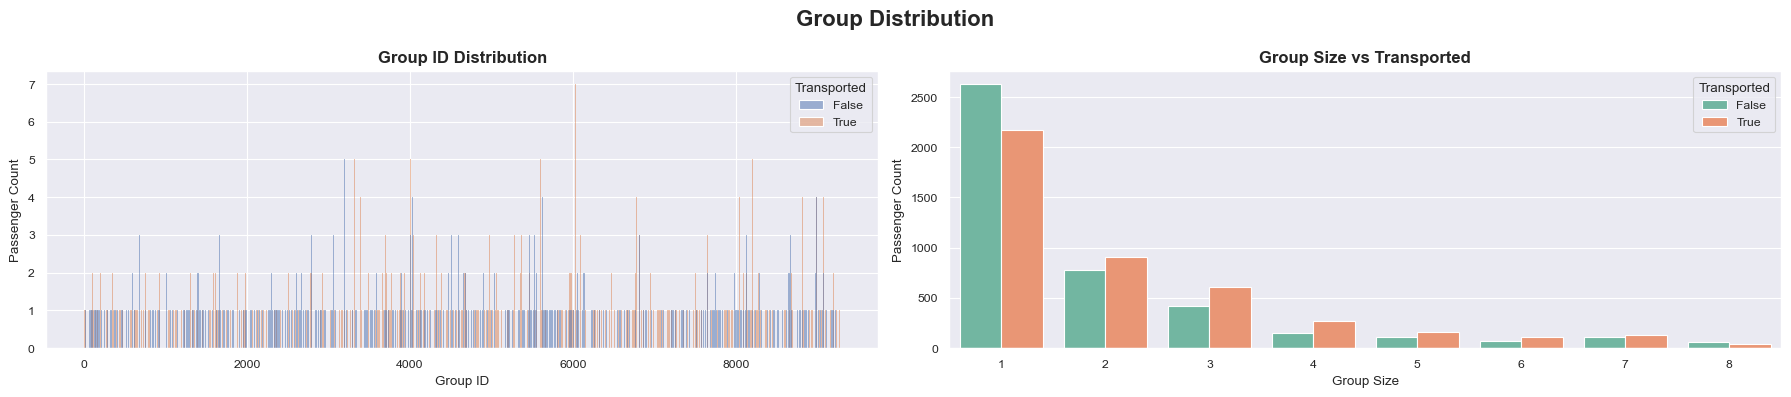

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# Left: Group ID distribution (can be very dense, useful only for spotting isolated/small groups)
sns.histplot(
    data=train_data,
    x='GroupID',
    hue='Transported',
    binwidth=1,
    ax=axes[0])
axes[0].set_title("Group ID Distribution", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Group ID")
axes[0].set_ylabel("Passenger Count")

# Right: Group Size distribution
sns.countplot(
    data=train_data,
    x='GroupSize',
    hue='Transported',
    ax=axes[1],
    palette='Set2'
)
axes[1].set_title("Group Size vs Transported", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Group Size")
axes[1].set_ylabel("Passenger Count")
# overall tittle
fig.suptitle("Group Distribution", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(image_save_path,
            "Group Distribution.png"), bbox_inches="tight")
plt.show()

**Key Observations:**
1. **Group Size Distribution:** Most passengers travel alone (~4,500 people) or in pairs (~1,700 people)
2. **Large Groups Rare:** Groups of 6+ passengers are extremely uncommon
3. **Transportation Balance:** All group sizes show roughly 50/50 split between transported/not transported
4. **No Group Size Effect:** Group size doesn't appear to influence transportation probability - solo travelers and groups have similar rates

##### Solo Travel
Flag variable to indicate if a passenger is traveling in group or by themself.

In [43]:
# Mark passengers traveling alone
train_data['IsSolo'] = (train_data['GroupSize'] == 1).astype(int)
test_data['IsSolo'] = (test_data['GroupSize'] == 1).astype(int)

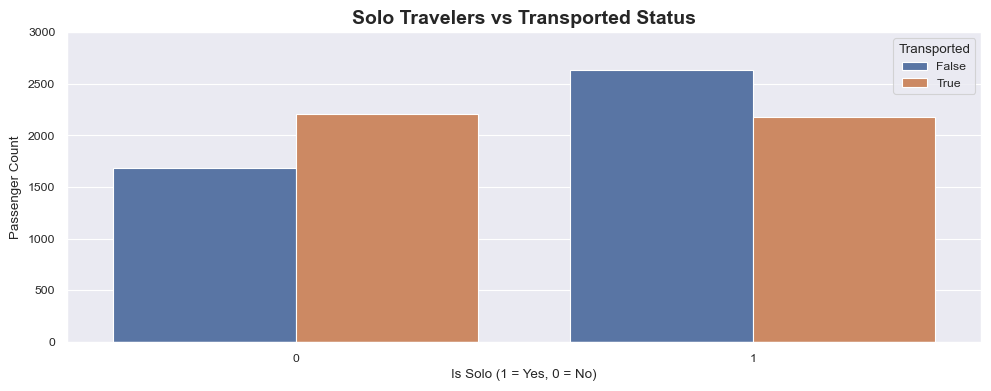

In [44]:
plt.figure(figsize=(10, 4))
# count plot for the solo travelers
sns.countplot(
    data=train_data,
    x='IsSolo',
    hue='Transported'
)

plt.title('Solo Travelers vs Transported Status',
          fontsize=14, fontweight="bold")
plt.xlabel('Is Solo (1 = Yes, 0 = No)')
plt.ylabel('Passenger Count')
plt.ylim(0, 3000)
plt.tight_layout()
plt.savefig(os.path.join(image_save_path,
            "Solo Travelers vs Transported Status.png"), bbox_inches="tight")
plt.show()

**Key Observation:**
- **Solo Travelers More Likely Transported:** Solo travelers (~57% transported) vs Group travelers (~45% transported)
- **Contradicts Previous Analysis:** While group size doesn't matter much, being alone vs being with anyone does make a difference.

##### Cabin Distribution
The cabin column has been separated into its components, cabin deck - incidating the levels in the ship, cabin numbers and cabin side. 

In [45]:
# Temporarily fill NaNs with placeholder
train_data['Cabin'].fillna('Z/9999/Z', inplace=True)
test_data['Cabin'].fillna('Z/9999/Z', inplace=True)

# Split into components
for df in [train_data, test_data]:
    df['CabinDeck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(int)
    df['CabinSide'] = df['Cabin'].str.split('/').str[2]

# Replace placeholders back with NaN
for df in [train_data, test_data]:
    df.loc[df['CabinDeck'] == 'Z', 'CabinDeck'] = np.nan
    df.loc[df['CabinNum'] == 9999, 'CabinNum'] = np.nan
    df.loc[df['CabinSide'] == 'Z', 'CabinSide'] = np.nan

# Drop original Cabin column
train_data.drop(columns='Cabin', inplace=True)
test_data.drop(columns='Cabin', inplace=True)

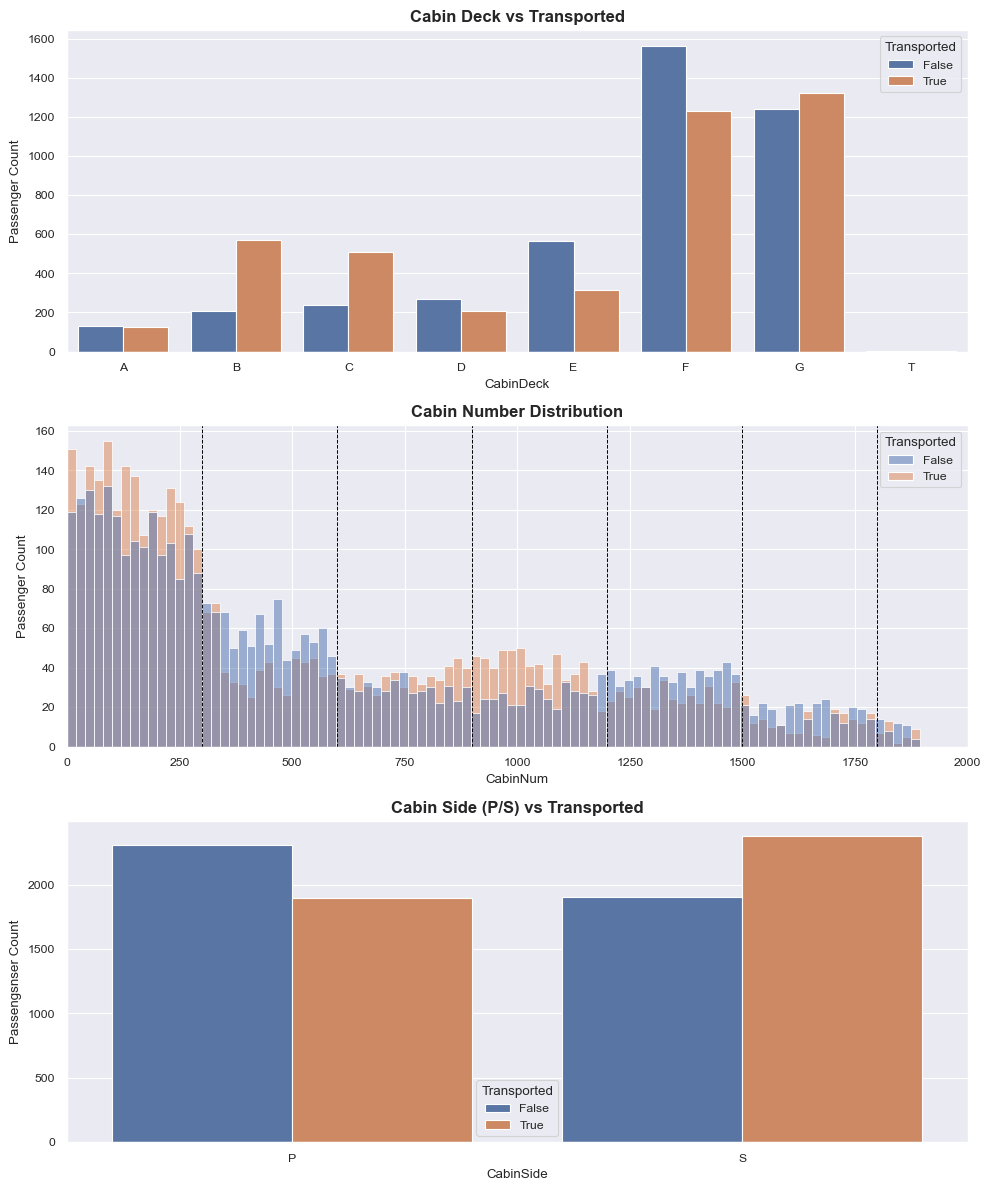

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# 1. Cabin Deck
sns.countplot(
    data=train_data,
    x='CabinDeck',
    hue='Transported',
    order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],
    ax=axes[0]
)
axes[0].set_title("Cabin Deck vs Transported", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Passenger Count")

# 2. Cabin Number
sns.histplot(
    data=train_data,
    x='CabinNum',
    hue='Transported',
    binwidth=20,
    ax=axes[1],
)
for line in range(300, 1801, 300):
    axes[1].axvline(line, color='black', linestyle='--', linewidth=0.7)
axes[1].set_xlim(0, 2000)
axes[1].set_title("Cabin Number Distribution", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Passenger Count")

# 3. Cabin Side
sns.countplot(
    data=train_data,
    x='CabinSide',
    hue='Transported',
    ax=axes[2]
)
axes[2].set_title("Cabin Side (P/S) vs Transported",
                  fontsize=12, fontweight="bold")
axes[2].set_ylabel("Passengsnser Count")

# # overall
# fig.suptitle("Cabin Distribution", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(image_save_path,
            "Cabin Distribution.png"), bbox_inches="tight")
plt.show()

**Key Observation:**

**1. Deck Patterns:**
- **B & C decks:** Higher transportation rates relative to passengers occupied 
- **E & F decks:** Lower transportation rates relative to passengers occupied
- **G deck:** Slighty flavours transportation

**2. Cabin Numbers**:
- **Lower Numbers (0-200):** Slightly more transported passengers
- **Middle Numbers (800-1200):** More transported passengers
- **Higher Numbers (1200+):** Sparse population

**3. Ship Side**:
- **Starboard (S):** Higher transported rates
- **Port (P):** Lower transported rates


##### Assigning Cabin Regions
Cabin Numbers are assigned to regions to understand the scope of passenger's cabin allocation.

In [47]:
# Define cabin region bins and labels
region_bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf]
region_labels = [1, 2, 3, 4, 5, 6, 7]

# Assign cabin regions using pd.cut
train_data['CabinRegion'] = pd.cut(
    train_data['CabinNum'],
    bins=region_bins, labels=region_labels).astype('Int64')
test_data['CabinRegion'] = pd.cut(
    test_data['CabinNum'],
    bins=region_bins, labels=region_labels).astype('Int64')

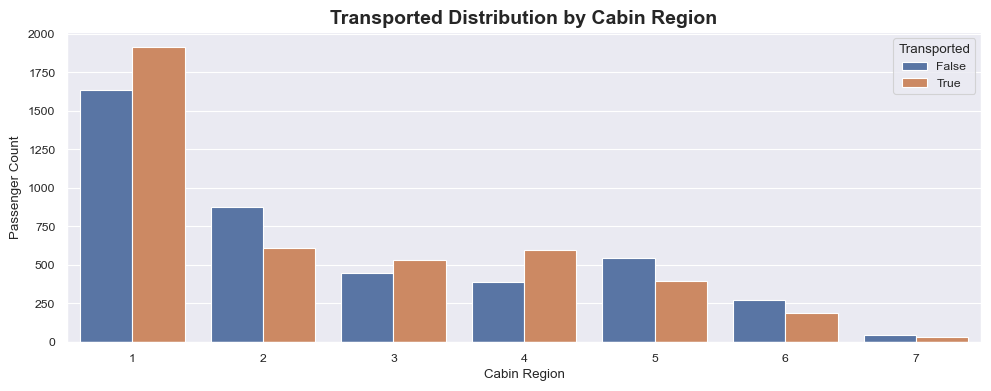

In [48]:
plt.figure(figsize=(10, 4))

sns.countplot(
    data=train_data,
    x='CabinRegion',
    hue='Transported',
)

plt.title('Transported Distribution by Cabin Region',
          fontsize=14, fontweight="bold")
plt.xlabel('Cabin Region')
plt.ylabel('Passenger Count')
plt.tight_layout()
plt.savefig(
    os.path.join(
        image_save_path, "Transported Distribution by Cabin Region.png"),
    bbox_inches="tight")
plt.show()

**Key Observations:**

**1. Region 1 (0-300):** Highest transportation rate (~54%) - most passengers transported

**2. Region 2 (300-600):** Lower transportation rate (~40%) - more stayed behind

**3. Regions 3-4 (600-1200):** Balanced to slight favor for transportation (~50-60%)

**4. Regions 5-7 (1200+):** Lower transportation rates and fewer passengers overall

The anomaly affected was a location-dependent, as the lower cabin number got transported more than others. 

##### Family Size
The number family size is obtain through countung Surnames from the Name column.

In [49]:
# Temporarily fill missing names
train_data['Name'].fillna('Unknown Unknown', inplace=True)
test_data['Name'].fillna('Unknown Unknown', inplace=True)

# Extract surname (last word)
train_data['Surname'] = train_data['Name'].str.split().str[-1]
test_data['Surname'] = test_data['Name'].str.split().str[-1]

# Combine surnames from both sets and count family size
all_surnames = pd.concat([train_data['Surname'], test_data['Surname']])
surname_counts = all_surnames.value_counts()

# Map surname frequency back to data
train_data['FamilySize'] = train_data['Surname'].map(surname_counts)
test_data['FamilySize'] = test_data['Surname'].map(surname_counts)

# Reassign NaNs where applicable
train_data.loc[train_data['Surname'] == 'Unknown', 'Surname'] = np.nan
test_data.loc[test_data['Surname'] == 'Unknown', 'Surname'] = np.nan

# Optional: treat very large groups as missing (likely erroneous merges)
train_data.loc[train_data['FamilySize'] > 100, 'FamilySize'] = np.nan
test_data.loc[test_data['FamilySize'] > 100, 'FamilySize'] = np.nan

# Drop raw Name column
train_data.drop(columns='Name', inplace=True)
test_data.drop(columns='Name', inplace=True)

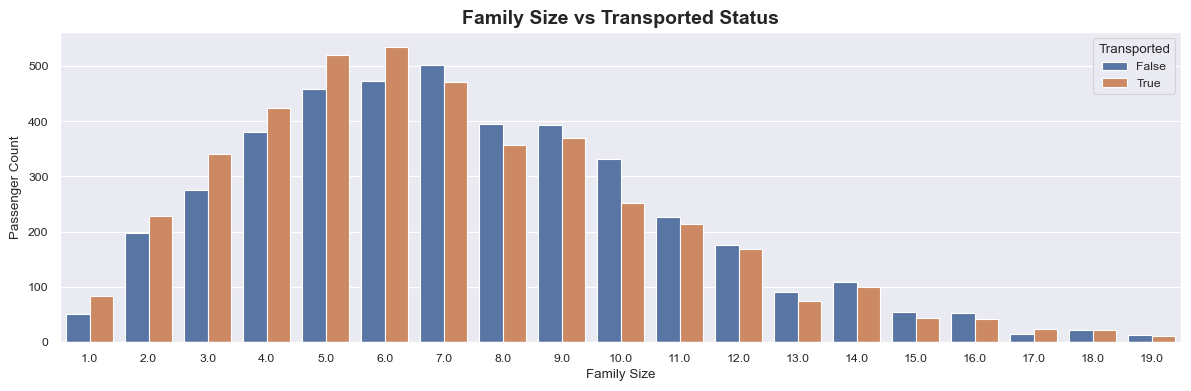

In [50]:
plt.figure(figsize=(12, 4))

sns.countplot(
    data=train_data,
    x='FamilySize',
    hue='Transported')

plt.title('Family Size vs Transported Status', fontsize=14, fontweight="bold")
plt.xlabel('Family Size')
plt.ylabel('Passenger Count')
plt.tight_layout()
plt.savefig(os.path.join(image_save_path,
            "Family Size vs Transported Status.png"), bbox_inches="tight")
plt.show()

**Key Observations:**

**1. Medium Family Favored:** Fmaily sizes 5-6 have highest transportation rates 

**2. Solo Traveler Less Likely:** Fmaily size 1 have lower transportation rates overall

**3. Large Family:** Family sizes 12+(becomes rare as size increase) has almost same transportation rates

**4. Small Family Favored:** Fmaily sizes 2-4 have higher transportation rates 


In [51]:
fig = px.treemap(
    train_data.dropna(),
    path=["Transported", "CryoSleep", "CabinSide", "CabinDeck"],
    color="CabinRegion")
fig.show()

In [52]:
fig = px.treemap(
    train_data.dropna(),
    path=["Transported", "CryoSleep", "CabinSide", "CabinDeck"],
    color="FamilySize")
fig.show()

In [53]:
fig = px.treemap(
    train_data.dropna(),
    path=["Transported", "CryoSleep", "CabinSide", "CabinDeck"],
    color="GroupSize")
fig.show()

In [54]:
fig = px.treemap(
    train_data.dropna(),
    path=["Transported", "HomePlanet", "CabinDeck"],
    color="Age")
fig.show()

**Key Observations**:

**1. Deck G, F & E:** These decks occupied by passengers form Earth mostly. 

**2. Deck A, B & C:** These decks occupied by passengers form Europa entirly. 

**3. Other Decks:** These decks have mixed occupants.

In [55]:
fig = px.treemap(
    train_data.dropna(),
    path=["Transported", "Destination", "CabinDeck"],
    color="Age")
fig.show()

In [56]:
fig = px.treemap(
    train_data.dropna(),
    path=["Transported", "CryoSleep", "AgeGroup", "CabinDeck"],
    color="Age")
fig.show()

### Precossing

In [57]:
# extracting target and features
target = train_data["Transported"].astype(int)
train_features = train_data.drop(columns=["Transported"]).copy()

#### Imputing Missing Values

In [58]:
# look at the missing values with engineered features
missing_data(train_features)

              MissingCount  MissingPercentage
PassengerId              0               0.00
HomePlanet             201               2.31
CryoSleep              217               2.50
Destination            182               2.09
Age                    179               2.06
VIP                    203               2.34
RoomService            181               2.08
FoodCourt              183               2.11
ShoppingMall           208               2.39
Spa                    183               2.11
VRDeck                 188               2.16
TotalSpend               0               0.00
NoSpendFlag              0               0.00
AgeGroup               179               2.06
GroupID                  0               0.00
GroupSize                0               0.00
IsSolo                   0               0.00
CabinDeck              199               2.29
CabinNum               199               2.29
CabinSide              199               2.29
CabinRegion            217        

In [59]:
# imputer instance
imputer = SpaceShipTitanicImputer()

In [60]:
# imputing data for train_features
train_impute_data = imputer.impute_all_features(train_features)

[INFO] Starting imputation pipeline...
	[INFO] CryoSleep imputed. Missing: 0
	[INFO] Spending features imputed. Total missing: 0
	[INFO] Age imputed. Missing: 0
	[INFO] Categorical features imputed. Total missing: 0
	[INFO] Cabin features imputed. Total missing: 0
	[INFO] Surname imputed. Missing: 0
[INFO] Imputation complete. Total missing values: 200


In [61]:
# imputing data for test_data
test_impute_data = imputer.impute_all_features(test_data)

[INFO] Starting imputation pipeline...
	[INFO] CryoSleep imputed. Missing: 0
	[INFO] Spending features imputed. Total missing: 0
	[INFO] Age imputed. Missing: 0
	[INFO] Categorical features imputed. Total missing: 0
	[INFO] Cabin features imputed. Total missing: 0
	[INFO] Surname imputed. Missing: 0
[INFO] Imputation complete. Total missing values: 94


In [62]:
# Combine surnames from both sets and count family size
all_surnames = pd.concat(
    [train_impute_data['Surname'], test_impute_data['Surname']])
surname_counts = all_surnames.value_counts()

# Map surname frequency back to data
train_impute_data['FamilySize'] = train_impute_data['Surname'].map(
    surname_counts)
test_impute_data['FamilySize'] = test_impute_data['Surname'].map(
    surname_counts)

In [63]:
missing_data(train_impute_data)

              MissingCount  MissingPercentage
PassengerId              0                0.0
HomePlanet               0                0.0
CryoSleep                0                0.0
Destination              0                0.0
Age                      0                0.0
VIP                      0                0.0
RoomService              0                0.0
FoodCourt                0                0.0
ShoppingMall             0                0.0
Spa                      0                0.0
VRDeck                   0                0.0
TotalSpend               0                0.0
NoSpendFlag              0                0.0
AgeGroup                 0                0.0
GroupID                  0                0.0
GroupSize                0                0.0
IsSolo                   0                0.0
CabinDeck                0                0.0
CabinNum                 0                0.0
CabinSide                0                0.0
CabinRegion              0        

In [64]:
missing_data(test_impute_data)

              MissingCount  MissingPercentage
PassengerId              0                0.0
HomePlanet               0                0.0
CryoSleep                0                0.0
Destination              0                0.0
Age                      0                0.0
VIP                      0                0.0
RoomService              0                0.0
FoodCourt                0                0.0
ShoppingMall             0                0.0
Spa                      0                0.0
VRDeck                   0                0.0
TotalSpend               0                0.0
NoSpendFlag              0                0.0
AgeGroup                 0                0.0
GroupID                  0                0.0
GroupSize                0                0.0
IsSolo                   0                0.0
CabinDeck                0                0.0
CabinNum                 0                0.0
CabinSide                0                0.0
CabinRegion              0        

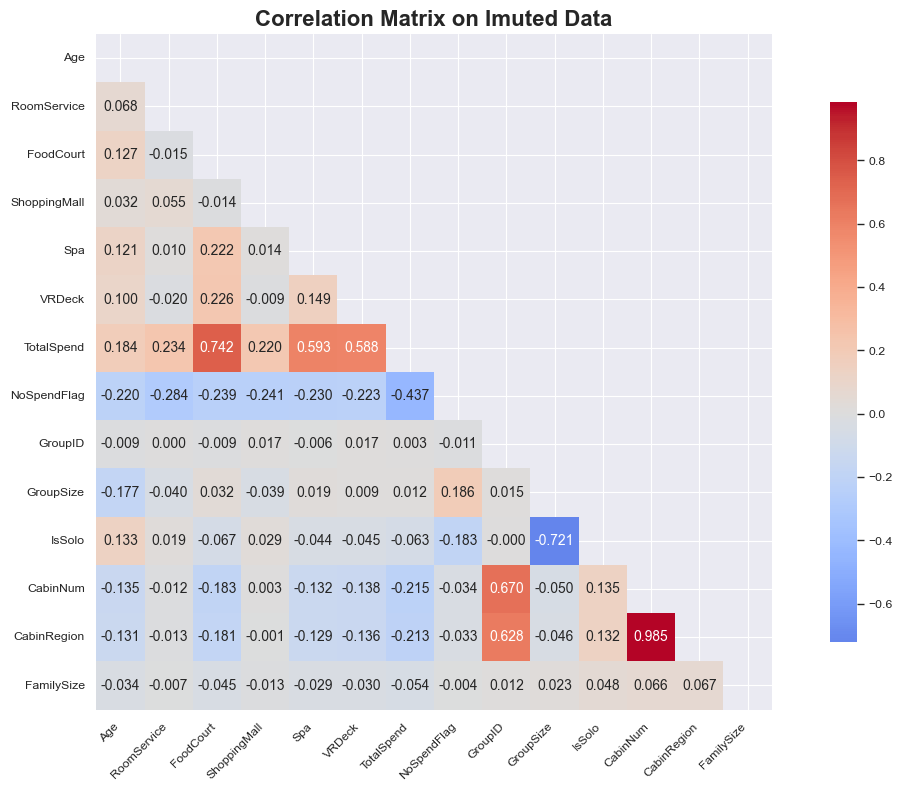

In [65]:
# correlation matrix for imputed data in trian set
correlation_matrix_imputed = correlation_matrix_visualise(train_impute_data,  train_impute_data.select_dtypes(
    include=[np.number]).columns.tolist(), title="Correlation Matrix on Imuted Data")

#### Droping Unwanted Features

In [66]:
# drop PassengerID, GroupID, Surname, GroupSize (GroupSize is related to FamilySize)
train_impute_data.drop(
    columns=["PassengerId", "GroupID", "Surname", "GroupSize"], axis=1, inplace=True)
test_impute_data.drop(
    columns=["PassengerId", "GroupID", "Surname", "GroupSize"], axis=1, inplace=True)

#### Handling Outliers
As the data contains zeros, log x+1 transformation will compress the outliers, decreasing skewness present in the data. The spending features is to be transformed, including total spend.

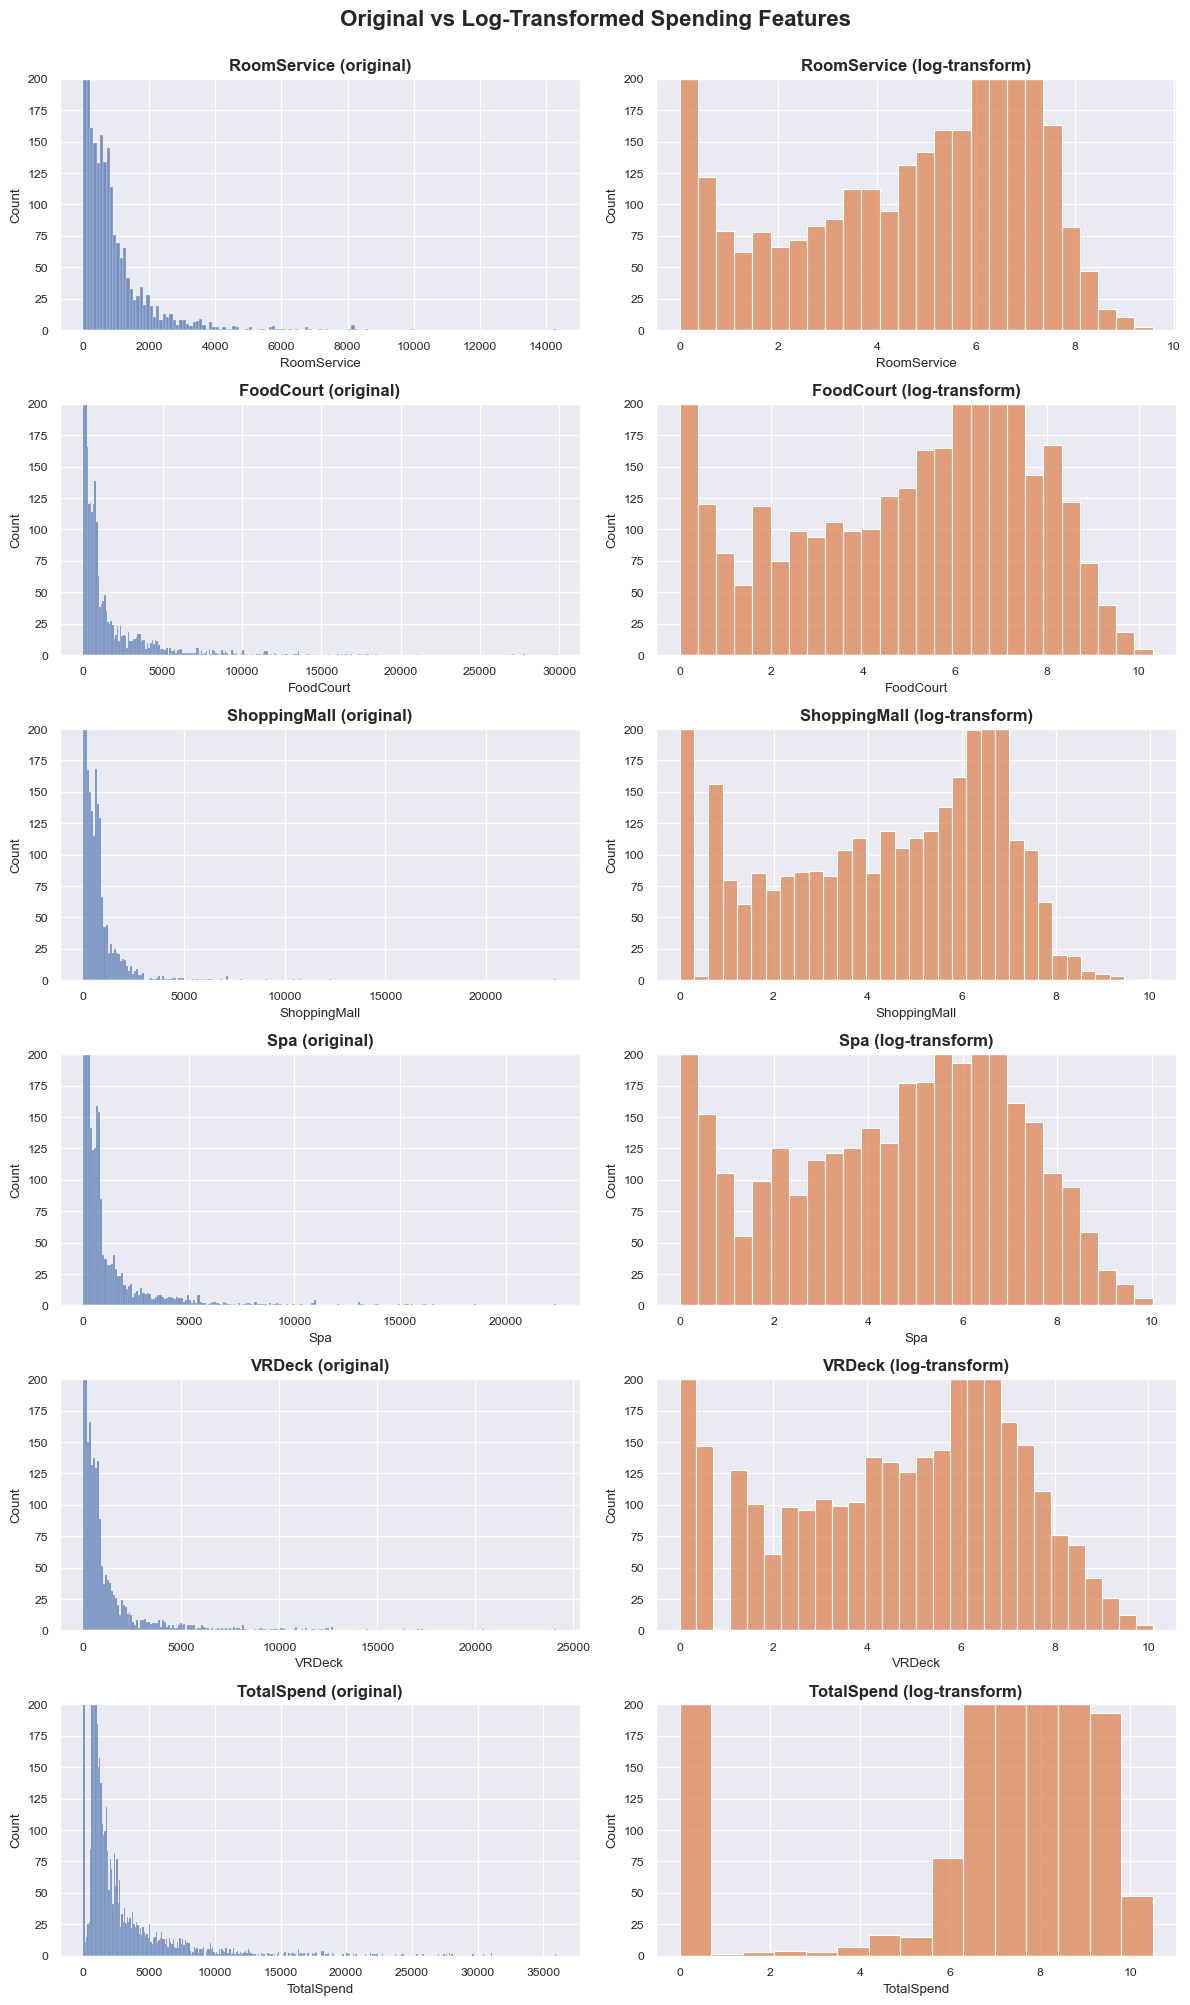

In [67]:
# Visualize original and log-transformed distributions of spending features
fig = plt.figure(figsize=(12, 20))
log_features = ['RoomService', 'FoodCourt',
                'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend']

for i, col in enumerate(log_features):
    # Original distribution
    plt.subplot(6, 2, 2 * i + 1)
    sns.histplot(train_impute_data[col], binwidth=100)
    plt.ylim([0, 200])
    plt.title(f'{col} (original)', fontsize=12, fontweight="bold")

    # Log-transformed distribution
    plt.subplot(6, 2, 2 * i + 2)
    # log1p is safer for 0s
    sns.histplot(np.log1p(train_impute_data[col]), color='C1')
    plt.ylim([0, 200])
    plt.title(f'{col} (log-transform)', fontsize=12, fontweight="bold")
fig.suptitle("Original vs Log-Transformed Spending Features",
             fontsize=16, fontweight="bold", y=1)
fig.tight_layout()
plt.savefig(os.path.join(image_save_path,
            "Original vs Log Transformed Spending Features.png"), bbox_inches="tight")
plt.show()

In [68]:
# # Apply log(1 + x) transformation to reduce skew
# for col in log_features:
#     train_impute_data[col] = np.log1p(
#         train_impute_data[col])       # safer and cleaner
#     test_impute_data[col] = np.log1p(test_impute_data[col])

In [69]:
log_transforamtion_pipeline = Pipeline(steps=[
    ("log_transform", FunctionTransformer(np.log1p, validate=True))
])

#### Scaling Data

Scaling all the spending, age and family size data, using robust scaler from sklearn library. It scales using by removing the median and dividing by the interquartile range (IQR). It doesn't change the shape of the distribution, and is resistant to the infulence of outliers. 

In [ ]:
# define scaler
scaler = RobustScaler()
# define scale features



scale_features = log_features + ["Age", "FamilySize"]


# scaler pipeline


scale_pipeline = Pipeline(steps=[







    ("robust_scaler", RobustScaler())







])

#### Encode Categorial Features

**CryoSleep** and **VIP** features can be label encoded as they are boolean in nature, while **HomePlanet**, **Destination**, **AgeGroup**, **CabinDeck**, **CabinSide** and **CabinRegion** needs to one-hot encoded, so no order is established.

In [71]:
# define boolean feature
boolean_features = ["CryoSleep", "VIP"]
#  boolean feature
boolean_pipeline = Pipeline(steps=[
    ("bool_to_int", FunctionTransformer(lambda x: x.astype(int), validate=True))
])

In [72]:
# define columns for one hot encoding
one_hot_encode_columns = ["HomePlanet", "CabinRegion", "Destination",
                          "AgeGroup", "CabinDeck", "CabinSide"]
# one hot encoding pipeline
categorical_pipeline = Pipeline(steps=[
    ("one_hot", OneHotEncoder(handle_unknown="ignore", dtype=int))
])

#### Preprocess Pipeline

In [73]:
# Combine all pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("log", log_transforamtion_pipeline, log_features),
    ("scaler", scale_pipeline, scale_features),
    ("bool",  boolean_pipeline, boolean_features),
    ("categorial", categorical_pipeline, one_hot_encode_columns)
])

In [74]:
# Fit and transform the train and test data
train_processed_data = preprocessor.fit_transform(train_impute_data)
test_processed_data = preprocessor.transform(test_impute_data)

### Training
Usage **Optuna** hyperparameter tuner to find the best parameters for **Random Forest**, **CatBoost Classifier**, **XGBoost Classifier**, and **LightGBM Classifier**, then train these models.

Additionally, implement ensemble methods including **Voting** and **Stacking** using the top three performing models to improve overall prediction accuracy.

In [92]:
# training class instance
trainer = SpaceShipTitanicModel(train_processed_data, target.values, 3, 20)

In [93]:
# hyperparameter tuning and training all model
trainer.train()

[I 2025-07-26 23:48:21,679] A new study created in memory with name: RandomForestClassifier


[INFO] Optimizing RandomForestClassifier (20 trials)...


[I 2025-07-26 23:48:47,355] Trial 0 finished with value: 0.7948942763743682 and parameters: {'n_estimators': 1000, 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7948942763743682.
[I 2025-07-26 23:48:54,975] Trial 1 finished with value: 0.7935136170867287 and parameters: {'n_estimators': 300, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7948942763743682.
[I 2025-07-26 23:49:07,510] Trial 2 finished with value: 0.7943190479922632 and parameters: {'n_estimators': 500, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7948942763743682.
[I 2025-07-26 23:49:11,816] Trial 3 finished with value: 0.7948942763743682 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7948942763

	[INFO] Training RandomForestClassifier with Best Parameters...


[I 2025-07-26 23:57:44,909] A new study created in memory with name: LogisticRegression


	[INFO] 3 Fold Cross-Validation Results:
		 Accuracy  : 0.7944
		 Precision : 0.7947
		 Recall    : 0.7944
		 ROC_AUC   : nan
	Model Trained.
[INFO] Optimizing LogisticRegression (20 trials)...


[I 2025-07-26 23:58:19,940] Trial 0 finished with value: 0.7922476620229917 and parameters: {'C': 5.299268465579451, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.7922476620229917.
[I 2025-07-26 23:58:20,430] Trial 1 finished with value: 0.7775253411368733 and parameters: {'C': 1.2058406276766664, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7922476620229917.
[I 2025-07-26 23:58:35,343] Trial 2 finished with value: 0.7921326401688397 and parameters: {'C': 16.411453846680097, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.7922476620229917.
[I 2025-07-26 23:58:35,594] Trial 3 finished with value: 0.783621380295601 and parameters: {'C': 0.3925780230343033, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7922476620229917.
[I 2025-07-26 23:58:35,989] Trial 4 finished with value: 0.7737297390611914 and parameters: {'C': 12.759027569416235, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with valu

	[INFO] Training LogisticRegression with Best Parameters...


[I 2025-07-27 00:01:55,882] A new study created in memory with name: CatBoostClassifier


	[INFO] 3 Fold Cross-Validation Results:
		 Accuracy  : 0.7949
		 Precision : 0.7991
		 Recall    : 0.7949
		 ROC_AUC   : nan
	Model Trained.
[INFO] Optimizing CatBoostClassifier (20 trials)...


[I 2025-07-27 00:02:14,264] Trial 0 finished with value: 0.7832754412499576 and parameters: {'learning_rate': 0.21821165404747786, 'depth': 6, 'iterations': 700, 'l2_leaf_reg': 4.437677732770018, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.7832754412499576.
[I 2025-07-27 00:02:58,104] Trial 1 finished with value: 0.7745322318869166 and parameters: {'learning_rate': 0.23265731657198985, 'depth': 8, 'iterations': 900, 'l2_leaf_reg': 2.4245054746818684, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.7832754412499576.
[I 2025-07-27 00:03:06,784] Trial 2 finished with value: 0.7951242803788916 and parameters: {'learning_rate': 0.01606316584398724, 'depth': 5, 'iterations': 400, 'l2_leaf_reg': 7.230596714385862, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.7951242803788916.
[I 2025-07-27 00:04:12,442] Trial 3 finished with value: 0.7737269200927258 and parameters: {'learning_rate': 0.2966834617497173, 'depth': 9, 'iterations': 800, 'l2_leaf_re

	[INFO] Training CatBoostClassifier with Best Parameters...
0:	learn: 0.6616300	total: 13.9ms	remaining: 8.3s
1:	learn: 0.6305899	total: 25.1ms	remaining: 7.51s
2:	learn: 0.6119403	total: 30.1ms	remaining: 5.98s
3:	learn: 0.5974496	total: 41.7ms	remaining: 6.22s
4:	learn: 0.5811362	total: 48.2ms	remaining: 5.74s
5:	learn: 0.5642620	total: 58.9ms	remaining: 5.83s
6:	learn: 0.5505432	total: 66.7ms	remaining: 5.65s
7:	learn: 0.5422178	total: 76.3ms	remaining: 5.64s
8:	learn: 0.5347700	total: 84.1ms	remaining: 5.52s
9:	learn: 0.5278063	total: 90ms	remaining: 5.31s
10:	learn: 0.5217011	total: 100ms	remaining: 5.36s
11:	learn: 0.5160173	total: 110ms	remaining: 5.41s
12:	learn: 0.5099686	total: 116ms	remaining: 5.26s
13:	learn: 0.5017828	total: 122ms	remaining: 5.13s
14:	learn: 0.4970060	total: 135ms	remaining: 5.25s
15:	learn: 0.4928818	total: 141ms	remaining: 5.15s
16:	learn: 0.4888560	total: 151ms	remaining: 5.18s
17:	learn: 0.4856893	total: 164ms	remaining: 5.3s
18:	learn: 0.4811878	total

[I 2025-07-27 00:11:44,228] A new study created in memory with name: XGBClassifier


	[INFO] 3 Fold Cross-Validation Results:
		 Accuracy  : 0.7986
		 Precision : 0.7999
		 Recall    : 0.7986
		 ROC_AUC   : nan
	Model Trained.
[INFO] Optimizing XGBClassifier (20 trials)...


[I 2025-07-27 00:11:47,398] Trial 0 finished with value: 0.796734268706774 and parameters: {'learning_rate': 0.24260635427244678, 'max_depth': 3, 'n_estimators': 300, 'min_child_weight': 6, 'subsample': 0.739119084215355, 'colsample_bytree': 0.7025867585650134, 'reg_alpha': 5.310557592421388, 'reg_lambda': 7.1272436737350375}. Best is trial 0 with value: 0.796734268706774.
[I 2025-07-27 00:11:57,982] Trial 1 finished with value: 0.7882214603860684 and parameters: {'learning_rate': 0.2329938014311764, 'max_depth': 7, 'n_estimators': 600, 'min_child_weight': 8, 'subsample': 0.7139303619225462, 'colsample_bytree': 0.6594580894986201, 'reg_alpha': 5.174599501884865, 'reg_lambda': 2.239182374223457}. Best is trial 0 with value: 0.796734268706774.
[I 2025-07-27 00:12:04,321] Trial 2 finished with value: 0.7940882102083345 and parameters: {'learning_rate': 0.21289280352974999, 'max_depth': 4, 'n_estimators': 500, 'min_child_weight': 2, 'subsample': 0.9148690619776042, 'colsample_bytree': 0.60

	[INFO] Training XGBClassifier with Best Parameters...


[I 2025-07-27 00:15:41,036] A new study created in memory with name: LGBMClassifier


	[INFO] 3 Fold Cross-Validation Results:
		 Accuracy  : 0.7971
		 Precision : 0.7985
		 Recall    : 0.7971
		 ROC_AUC   : nan
	Model Trained.
[INFO] Optimizing LGBMClassifier (20 trials)...


[I 2025-07-27 00:15:44,530] Trial 0 finished with value: 0.7937434622761272 and parameters: {'learning_rate': 0.22044178993537514, 'num_leaves': 245, 'n_estimators': 700, 'min_data_in_leaf': 57, 'feature_fraction': 0.685300140939629, 'bagging_fraction': 0.9896452417416727, 'reg_alpha': 3.2136672184843307, 'reg_lambda': 6.625459771299847}. Best is trial 0 with value: 0.7937434622761272.
[I 2025-07-27 00:15:49,657] Trial 1 finished with value: 0.7887968475832983 and parameters: {'learning_rate': 0.2880411098610864, 'num_leaves': 293, 'n_estimators': 600, 'min_data_in_leaf': 41, 'feature_fraction': 0.9000225907751045, 'bagging_fraction': 0.790362375725511, 'reg_alpha': 1.7043484236354345, 'reg_lambda': 4.816931280594745}. Best is trial 0 with value: 0.7937434622761272.
[I 2025-07-27 00:15:57,346] Trial 2 finished with value: 0.7846552270544106 and parameters: {'learning_rate': 0.2781834458304703, 'num_leaves': 13, 'n_estimators': 800, 'min_data_in_leaf': 88, 'feature_fraction': 0.87001205

	[INFO] Training LGBMClassifier with Best Parameters...
	[INFO] 3 Fold Cross-Validation Results:
		 Accuracy  : 0.7982
		 Precision : 0.7993
		 Recall    : 0.7982
		 ROC_AUC   : nan
	Model Trained.

[INFO] The best overall model is CatBoostClassifier with 0.7986 accuracy.


In [94]:
# training ensemble voting
trainer.ensemble_model_voting()

[INFO] Training VotingEnsemble with Best Parameters...
0:	learn: 0.6660640	total: 14.8ms	remaining: 8.87s
1:	learn: 0.6416295	total: 19.2ms	remaining: 5.73s
2:	learn: 0.6175730	total: 32.1ms	remaining: 6.39s
3:	learn: 0.6009305	total: 39.3ms	remaining: 5.85s
4:	learn: 0.5840513	total: 48.4ms	remaining: 5.76s
5:	learn: 0.5714288	total: 54.4ms	remaining: 5.38s
6:	learn: 0.5603785	total: 64.5ms	remaining: 5.46s
7:	learn: 0.5513305	total: 74.9ms	remaining: 5.54s
8:	learn: 0.5407541	total: 82.6ms	remaining: 5.42s
9:	learn: 0.5327634	total: 92.8ms	remaining: 5.47s
10:	learn: 0.5235875	total: 98.3ms	remaining: 5.26s
11:	learn: 0.5162938	total: 110ms	remaining: 5.41s
12:	learn: 0.5074039	total: 126ms	remaining: 5.69s
13:	learn: 0.5003493	total: 135ms	remaining: 5.64s
14:	learn: 0.4954728	total: 145ms	remaining: 5.64s
15:	learn: 0.4903332	total: 158ms	remaining: 5.76s
16:	learn: 0.4847462	total: 164ms	remaining: 5.62s
17:	learn: 0.4798182	total: 174ms	remaining: 5.63s
18:	learn: 0.4763061	total

In [95]:
# training ensemble stacking
trainer.ensemble_model_stacking()

[INFO] Training StackingEnsemble with Best Parameters...
[INFO] 3 Fold Cross-Validation Results:
	Accuracy  : 0.7962
	Precision : 0.8007
	Recall    : 0.7962
	ROC_AUC   : nan
	Model Trained.


In [96]:
# Flatten the nested 'metrics' dict in each result dictionary
flat_results = []
for res in trainer.results:
    # Copy top-level keys except 'metrics'
    flat_res = {k: v for k, v in res.items() if k != "metrics"}
    # Expand 'metrics' dict items into flat_res
    flat_res.update(res.get("metrics", {}))
    flat_results.append(flat_res)

# Create pandas DataFrame
df_results = pd.DataFrame(flat_results)

# Set model names as index (this is the key fix!)
df_results = df_results.set_index("model")
# Save as csv file
df_results.to_csv("result.csv", index=True)
df_results

,best_params,n_trails,cv_folds,accuracy,roc_auc,precision,recall,f1
model,,,,,,,,
RandomForestClassifier,"{'n_estimators': 900, 'max_depth': 16, 'min_sa...",20,3,0.794434,NaN,0.794674,0.794434,0.794377
LogisticRegression,"{'C': 0.011011390843553959, 'penalty': 'l1', '...",20,3,0.794894,NaN,0.799110,0.794894,0.794047
CatBoostClassifier,"{'learning_rate': 0.07769754327731407, 'depth'...",20,3,0.798575,NaN,0.799854,0.798575,0.798336
XGBClassifier,"{'learning_rate': 0.07914607158509666, 'max_de...",20,3,0.797079,NaN,0.798539,0.797079,0.796808
LGBMClassifier,"{'learning_rate': 0.10830568470670159, 'num_le...",20,3,0.798230,NaN,0.799256,0.798230,0.798043
VotingEnsemble,"{'voting': 'soft', 'estimators': ['CatBoostCla...",N/A,3,0.800070,NaN,0.801377,0.800070,0.799836
StackingEnsemble,"{'estimators': ['CatBoostClassifier', 'XGBClas...",N/A,3,0.796159,NaN,0.800666,0.796159,0.795272


In [97]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Clean, modern default styling
fig = go.Figure()

# Add traces for each metric with custom colors/markers
fig.add_trace(go.Scatter(
    x=df_results.index,
    y=df_results['accuracy'],
    mode='lines+markers',
    name='Acc.',
    line=dict(color='#17becf', width=3),
    marker=dict(size=8, symbol='circle')
))

fig.add_trace(go.Scatter(
    x=df_results.index,
    y=df_results['precision'],
    mode='lines+markers',
    name='Prec.',
    line=dict(color='#ff7f0e', width=3),
    marker=dict(size=8, symbol='square')
))

fig.add_trace(go.Scatter(
    x=df_results.index,
    y=df_results['recall'],
    mode='lines+markers',
    name='Recall',
    line=dict(color='#2ca02c', width=3),
    marker=dict(size=8, symbol='triangle-up')
))

fig.add_trace(go.Scatter(
    x=df_results.index,
    y=df_results['f1'],
    mode='lines+markers',
    name='F1 Score',
    line=dict(color='#9467bd', width=3),
    marker=dict(size=8, symbol='diamond')
))

# fig.add_trace(go.Scatter(
#     x=df_results.index,
#     y=df_results['roc_auc'],
#     mode='lines+markers',
#     name='F1 Score',
#     line=dict(color='#9467bd', width=3),
#     marker=dict(size=8, symbol='diamond')
# ))

# Update layout to match your desired style
fig.update_layout(
    title="Spaceship Titanic: Model Performance Comparison",
    title_font_size=18,
    title_x=0.5,
    xaxis_title="Model Name",
    yaxis_title="Metric Score",
    template="plotly_white",
    showlegend=True,
    legend=dict(
        orientation="h",
        y=1.02,
        x=0.5,
        xanchor='center'
    ),
    width=1000,
    height=600,
    margin=dict(l=50, r=50, t=100, b=150)  # Increase bottom margin
)

# Update x-axis for better model name display
fig.update_xaxes(
    tickangle=45,
    title_font_size=14,
    tickfont_size=12,
    tickmode='linear',
    title_standoff=25  # More space between axis and title
)

# Update y-axis
fig.update_yaxes(
    title_font_size=14,
    tickfont_size=12
)
fig.write_image(os.path.join(image_save_path, "model_train_metrics.png"),
                width=1200, height=800, scale=2)  # Static
fig.show()

In [98]:
# predicting transported over test data#
for model_dict in trainer.trained_models:
    # extract model name and trained model
    model_name = model_dict["model_name"]
    model = model_dict["trained_model"]
    print(f"[INFO] Prediction Using {model_name}...")
    # predicting
    predictions_bool = model.predict(test_processed_data).astype(bool)
    # Create submission DataFrame with ID and prediction columns
    submission_df = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Transported": predictions_bool
    })
    submission_df.to_csv(os.path.join(
        kaggle_submission_path, f"{model_name}_submission.csv"), index=False)
    print(f"\tPredicted &  Saved - {kaggle_submission_path}")

[INFO] Prediction Using RandomForestClassifier...
	Predicted &  Saved - D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Kaggle_Submissions
[INFO] Prediction Using LogisticRegression...
	Predicted &  Saved - D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Kaggle_Submissions
[INFO] Prediction Using CatBoostClassifier...
	Predicted &  Saved - D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Kaggle_Submissions
[INFO] Prediction Using XGBClassifier...
	Predicted &  Saved - D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Kaggle_Submissions
[INFO] Prediction Using LGBMClassifier...
	Predicted &  Saved - D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Kaggle_Submissions
[INFO] Prediction Using VotingEnsemble...
	Predicted &  Saved - D:\MScDataScience\9.Research_Methods\Assignment\Assignment3\Spaceship_Titanic\Kaggle_Submissions
[INFO] Prediction U

### XAI

From Kaggle Submission the best model is Stacking, lets understand why.